# Proyecto: Ensembles
### Scikit Learn

En este proyecto vamos a aprender cómo trabajar con diferentes técnicas de ensembles utilizando la librería de scikit-learn. Vamos a aprender a:
* Entrenar modelos de ensembles.
* Usar la técnica de validación cruzada para ajustar hiperparámetros.
* Interpretar estos hiperparámetros.
* Usar pipelines de Scikit learn con ensembles.
* Hacer predicciones con pipelines y ensembles.

Durante el proyecto se hará uso de diferentes paquetes de Python que importan a continuación:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as ma
import matplotlib.font_manager as fm

El siguiente cóidgo servirá para embeber los gráficos en el propio notebook en lugar de abrirlos en nueva ventana.

In [2]:
%matplotlib inline

# Clasificación binaria

## Datasets sintéticos

Antes de trabajar con un conjunto de datos real de morosidad, vamos a analizar los distintos métodos de ensembles vistos en las clases teóricas sobre una serie de conjuntos de datos sintéticos.

Scikit learn provee una serie de funciones para generar conjuntos de datos sintéticos con dos dimensiones (variables).
* **Moons** (función <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">sklearn.datasets.make_moons</a>): Dos semicírculos intercalados
* **Datos linealmente separables** (función <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html">sklearn.datasets.make_classification</a>). Esta función es en realidad suficientemente genérica para generar datasets de más de 2 dimensiones y más de 2 clases.
* **Circles** (función <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html">sklearn.datasets.make_circles</a>): Genera un círculo grande conteniendo a otro círculo más pequeño.

Todos los datasets están normalizados para que cada variable tenga media 0 y desviación típica 1. 

Visualicemos tres ejemplos de los datasets:

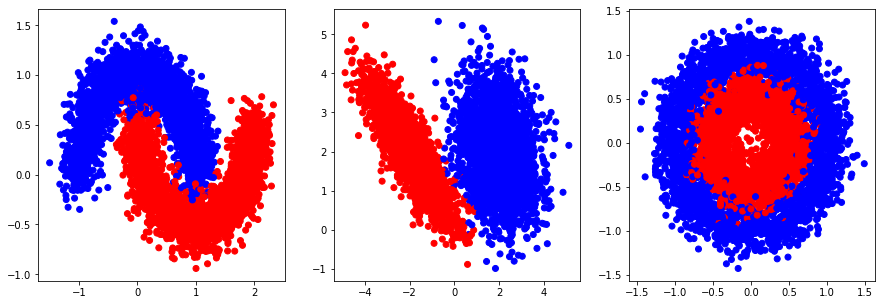

In [3]:
from sklearn import datasets

X_moons,y_moons = datasets.make_moons(n_samples=5000,noise=0.15,random_state=1)
X_linear, y_linear =  datasets.make_classification(n_samples=5000, n_features=2,
                                                   n_informative=2, n_redundant=0,
                                                   n_clusters_per_class=1, flip_y=-1,
                                                   class_sep=2, random_state=1)
X_circles, y_circles = datasets.make_circles(n_samples=5000, noise=0.15,factor=0.5,random_state=1)

cm = ma.ListedColormap(['#0000FF', '#FF0000'])    # blue, red
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=cm)
plt.subplot(1,3,2)
plt.scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap=cm)
plt.subplot(1,3,3)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap=cm)


plt.show()

Recordemos que para medir la capacidad de generalización del modelo, hay que generar un conjunto de test que únicamente sirva para medir el rendimiento. Es decir, este conjunto de test no debe ser utilizado para entrenar el modelo ni ajustar los hiperparámetros. El siguiente código, genera los conjuntos de entrenamiento y test para los tres datasets sintéticos (circles, mooons y linear) utilizando el 80% de los datos para entrenamiento (y ajuste de hiperparámetros) y el 20% de los datos para test.

In [6]:
from sklearn.model_selection import train_test_split

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons, y_moons, test_size=0.20, random_state=314)
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.20, random_state=314)
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(X_circles, y_circles, test_size=0.20, random_state=314)


Una vez tenemos genrada la división de entranamiento y test, vamos a hacer un ajuste de hiperparámetros de manera sistemática para los distintos algoritmos de ensembles y mediante un conjunto de validación utilizando la función <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">GridSearchCV</a> de scikit learn. Recordemos que algunos de los algoritmos de ensembles vistos en clase han sido:
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html">BaggingClassifier</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">RandomForestClassifier</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html">AdaBoostClassifier</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">GradientTreeBoostingClassifier</a>
* <a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn">XGBClassifier</a>

A modo de ejemplo, el siguiente código encuentra los valores óptimos de los parámetros de BaggingClassifier para el dataset circles utilizando una validación cruzada de 5-fold (por defecto, GridSearchCV hace validación cruzada estratificada). El campo **mean_test_score** de la tabla de resultados devuelve el acierto promedio (hemos puesto scoring="accuracy") sobre los 5 folds de validación cruzada. Se han incluido además en la búsqueda, un <a href="https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html">clasificador dummy</a>, una <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html"> regresión logística</a> (modelo lineal) y un <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">árbol de decisión</a> para poder evaluar la mejora de los ensembles respecto a estos algoritmos "más básicos". Aunque es posible probar varios clasificadores en un único pipeline, por simplicidad, el siguiente código genera un pipeline por cada tipo de clasificador y hace una búsqueda de hiperparámetros por cada pipeline para luego quedarse, entre todos, con aquel pipeline con menor error en validación cruzada.

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

classifiers = {
    'DT': DecisionTreeClassifier(random_state=1),
    'Bagging': BaggingClassifier(random_state=1,n_jobs=-1),
    'logisticRegression': LogisticRegression(random_state=1,solver='lbfgs'),
    'dummy': DummyClassifier(random_state=1,strategy='most_frequent')
}

params = {
            'DT': {
                       'max_depth':[2,4], 
                       'min_samples_split':[1,10]
                    },
            'Bagging':{
                    'n_estimators':[2,5,10,20,50,100,500,1000],
                    'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0]
                    },
            'logisticRegression': {
                    'C':[1e-3,1e-2,1e-1,1,10,100,1000]
                    },
            'dummy': {
                     }
         }


#######
# GRID SEARCH
#######

clf={}
for name in list(params.keys()):
    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(classifiers[name], params[name], 
                             scoring='accuracy', 
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
    clf[name].fit(X_circles, y_circles)

**********
DT
**********
Fitting 5 folds for each of 4 candidates, totalling 20 fits
**********
Bagging
**********
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.1min finished


**********
logisticRegression
**********
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


**********
dummy
**********
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


El siguiente código, unifica los resultados del diccionario <code>clf</code> en la tabla <code>resultado</code> que nos permite elegir el mejor modelo en base al acierto en **validación**.

In [16]:
from sklearn.metrics import accuracy_score

# compute results
test_scores = []


for name in list(params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(clf[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(clf[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]
    acc_cv_test = aux['mean_test_score']
    acc_cv_train = aux['mean_train_score']

    acc_train = accuracy_score(y_circles_train, clf[name].predict(X_circles_train))
    acc_test = accuracy_score(y_circles_test, clf[name].predict(X_circles_test))

      
    test_scores.append((name,acc_train,acc_cv_train,acc_cv_test,acc_test))
    
# mirar el rendimiento en validacion para obtener el mejor modelo
resultado = pd.DataFrame(test_scores,columns=['Classifier','accuracy_train','accuracy_CV_train','accuracy_validation','accuracy_test'])

display(resultado)

best_clas = resultado.sort_values(by="accuracy_validation",ascending=False).iloc[0]['Classifier']

print("*** El mejor clasificador es: ", best_clas)

DT
Número de configuraciones:  4
Bagging
Número de configuraciones:  40
logisticRegression
Número de configuraciones:  7
dummy
Número de configuraciones:  1


,Classifier,accuracy_train,accuracy_CV_train,accuracy_validation,accuracy_test
0,DT,0.93200,0.93205,0.9258,0.925
1,Bagging,0.96550,0.96540,0.9518,0.959
2,logisticRegression,0.50050,0.50590,0.4798,0.508
3,dummy,0.49825,0.50000,0.5000,0.507


*** El mejor clasificador es:  Bagging


Observar que en el código anterior, ha sido suficiente con hacer <code>clf[name].predict</code> para hacer las predicciones de la mejor configuración de hiperparámetros para cada tipo de clasificador. No obstante, el mejor modelo está guardado en el atributo **best_estimator_** del objeto GridSearchCV. Este modelo es el modelo entrenado sobre todos los datos de entrenamiento y considerando los mejores parámetros del proceso de validación cruzada.

Como ejemplo, observar que las siguientes líneas de código obtienen los mismos resultados para el caso del BaggingClassifier.

In [17]:
print(accuracy_score(y_circles_test,clf['Bagging'].best_estimator_.predict(X_circles_test)))
print(accuracy_score(y_circles_test,clf['Bagging'].predict(X_circles_test)))

0.959
0.959


### AJUSTE DE HIPERPARÁMETROS (GridSearchCV)


Para cada uno de los tres datasets sintéticos (moons, linear, circles), realizaremos un ajuste de hiperparámetros por 5-CV sobre los modelos de ensemble BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientTreeBoostingClassifier y XGBClassifier dejando como resultados de referencia lo de los modelos de árboles de decisión, regresión logística y el dummy classifier.

In [18]:
# Comprobamos el "prior" de la variable target en los distintos datasets:

print("Moons Dataset: ")
print("% Elementos clase 1 de la var. target en train: ", 100*np.mean(y_moons_train))
print("% Elementos clase 1 de la var. target en test: ", 100*np.mean(y_moons_test))

print("**********")

print("Linear Dataset: ")
print("% Elementos clase 1 de la var. target en train: ", 100*np.mean(y_linear_train))
print("% Elementos clase 1 de la var. target en test: ", 100*np.mean(y_linear_test))

print("**********")

print("Circles Dataset: ")
print("% Elementos clase 1 de la var. target en train: ", 100*np.mean(y_circles_train))
print("% Elementos clase 1 de la var. target en test: ", 100*np.mean(y_circles_test))

Moons Dataset: 
% Elementos clase 1 de la var. target en train:  50.175000000000004
% Elementos clase 1 de la var. target en test:  49.3
**********
Linear Dataset: 
% Elementos clase 1 de la var. target en train:  49.675000000000004
% Elementos clase 1 de la var. target en test:  51.300000000000004
**********
Circles Dataset: 
% Elementos clase 1 de la var. target en train:  50.175000000000004
% Elementos clase 1 de la var. target en test:  49.3


Comprobamos que los datos están balanceados por lo que se decide utilizar el "accuracy" como métrica para comrpobar el rendimiento de los distintos modelos. Procedemos a definir las búsquedas de hiperparámetros para los distintos modelos en cada dataset, los resultados se recogen a continuación.

### "Moons" Dataset:

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

classifiers = {
    'Bagging': BaggingClassifier(random_state=1,n_jobs=-1),
    'RandomForest': RandomForestClassifier(criterion='gini', max_features='auto', bootstrap=True, 
                                           oob_score=False, n_jobs=-1, random_state=1),
    'AdaBoost': AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', random_state=1),
    'GradientBoosting': GradientBoostingClassifier(loss='deviance',random_state=1,n_iter_no_change=None,tol=0.0001),
    'XGBoost': XGBClassifier(objective ='binary:logistic', booster='gbtree', n_jobs=-1, random_state=1),
    'DT': DecisionTreeClassifier(random_state=1),
    'logisticRegression': LogisticRegression(random_state=1,solver='lbfgs'),
    'dummy': DummyClassifier(random_state=1,strategy='most_frequent')
}

params = {
            'Bagging':{
                'n_estimators':[12,14,16,18],
                'max_samples': [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]
                    },
            'RandomForest':{
                'n_estimators':[800,900,1000],
                'max_depth':[12,14,16],
                'min_samples_split':[2,3,30],
                #'min_samples_leaf':[1,10,100],
                'max_samples': [0.4,0.5,0.6]
                    },
            'AdaBoost':{
                'n_estimators':[800,900,1000],
                'learning_rate':[0.01,0.05,0.1,0.2,0.3]
                    },
            'GradientBoosting':{
                'learning_rate':[0.01,0.015],
                'n_estimators':[700,750],
                'subsample':[0.35,0.4],
                'min_samples_split':[25,30],
                #'min_samples_leaf':[12,14,16,18],   
                'max_depth':[20,25],                
                'max_features':[0.85,0.9],
                #'validation_fraction':[0.1,0.15],
                #'n_iter_no_change':[5,10],               
                #'ccp_alpha': [0.0,0.5]
                    },
            'XGBoost':{
                'learning_rate':[0.01,1],
                'n_estimators':[500,1000],
                'colsample_bytree':[0.1,1],
                'max_depth':[1,10], 
                'lambda':[0.1,1],
                'alpha':[0.1,1]
                    },
            'DT': {
                'max_depth':[4,5,6,8,10], 
                'min_samples_split':[2,3,30]
                    },
            'logisticRegression': {
                    'C':[1e-3,1e-2,1e-1,1,10,100,1000]
                    },
            'dummy': {}
         }

#######
# GRID SEARCH
#######

clf={}
for name in list(params.keys()):

    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(classifiers[name], params[name], 
                             scoring='accuracy', 
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
    clf[name].fit(X_moons_train, y_moons_train)

**********
Bagging
**********
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   28.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


**********
RandomForest
**********
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 14.8min finished


**********
AdaBoost
**********
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.4min finished


**********
GradientBoosting
**********
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 15.8min finished


**********
XGBoost
**********
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.8min finished


**********
DT
**********
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


**********
logisticRegression
**********
Fitting 5 folds for each of 7 candidates, totalling 35 fits
**********
dummy
**********
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [21]:
#######
# BEST ESTIMATOR
#######

best_estims={}

for name in list(params.keys()):
    print("**********")
    print(name)
    print("**********")
    best_estims[name] = clf[name].best_estimator_
    print(best_estims[name])

**********
Bagging
**********
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=0.3, n_estimators=16, n_jobs=-1,
                  oob_score=False, random_state=1, verbose=0, warm_start=False)
**********
RandomForest
**********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
**********
AdaBoost
**********
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=900, random

In [22]:
from sklearn.metrics import accuracy_score

# compute results
test_scores = []

for name in list(params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(clf[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(clf[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]
    acc_cv_test = aux['mean_test_score']
    acc_cv_train = aux['mean_train_score']

    acc_train = accuracy_score(y_moons_train, clf[name].predict(X_moons_train))
    acc_test = accuracy_score(y_moons_test, clf[name].predict(X_moons_test))

    test_scores.append((name,acc_train,acc_cv_train,acc_cv_test,acc_test))
    
# mirar el rendimiento en validacion para obtener el mejor modelo
resultado_moons = pd.DataFrame(test_scores,columns=['Classifier','accuracy_train','accuracy_CV_train','accuracy_validation','accuracy_test'])

display(resultado_moons)

best_clas = resultado_moons.sort_values(by="accuracy_validation",ascending=False).iloc[0]['Classifier']

print("*** El mejor clasificador es: ", best_clas)

Bagging
Número de configuraciones:  36
RandomForest
Número de configuraciones:  81
AdaBoost
Número de configuraciones:  15
GradientBoosting
Número de configuraciones:  64
XGBoost
Número de configuraciones:  64
DT
Número de configuraciones:  15
logisticRegression
Número de configuraciones:  7
dummy
Número de configuraciones:  1


,Classifier,accuracy_train,accuracy_CV_train,accuracy_validation,accuracy_test
0,Bagging,0.99125,0.990688,0.98875,0.988
1,RandomForest,0.99600,0.995625,0.98900,0.990
2,AdaBoost,0.99150,0.993063,0.98800,0.989
3,GradientBoosting,0.99875,0.999437,0.98950,0.990
4,XGBoost,0.99525,0.995875,0.98700,0.989
5,DT,0.99075,0.991063,0.98500,0.987
6,logisticRegression,0.87900,0.878500,0.87850,0.876
7,dummy,0.50175,0.501750,0.50175,0.493


*** El mejor clasificador es:  GradientBoosting


### "Linear" Dataset:

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

classifiers = {
    'Bagging': BaggingClassifier(random_state=1,n_jobs=-1),
    'RandomForest': RandomForestClassifier(criterion='gini', max_features='auto', bootstrap=True, oob_score=False, n_jobs=-1, random_state=1),
    'AdaBoost': AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', random_state=1),
    'GradientBoosting': GradientBoostingClassifier(loss='deviance',random_state=1,n_iter_no_change=None,tol=0.0001),
    'XGBoost': XGBClassifier(objective ='binary:logistic', booster='gbtree', n_jobs=-1, random_state=1),
    'DT': DecisionTreeClassifier(random_state=1),
    'logisticRegression': LogisticRegression(random_state=1,solver='lbfgs'),
    'dummy': DummyClassifier(random_state=1,strategy='most_frequent')
}

params = {
            'Bagging':{
                'n_estimators':[2,5,10,12,14,16,18,50,100,1000],
                'max_samples': [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1]
                    },
            'RandomForest':{
                'n_estimators':[100,500,800],
                'max_depth':[2,5,10],
                'min_samples_split':[2,50,100],
                #'min_samples_leaf':[1,10,100],
                'max_samples': [0.1,0.25,0.9]
                    },
            'AdaBoost':{
                'n_estimators':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,50,100],
                'learning_rate':[0.01,0.05,0.1,0.15,0.25,0.5,1]
                    },
            'GradientBoosting':{
                'learning_rate':[0.05,0.1],
                'n_estimators':[200,300],
                'subsample':[0.35,0.4],
                'min_samples_split':[20,25],
                #'min_samples_leaf':[12,14,16,18],   
                'max_depth':[10,15],                
                'max_features':[0.55,0.6],
                #'validation_fraction':[0.1,0.15],
                #'n_iter_no_change':[5,10],               
                #'ccp_alpha': [0.0,0.5]
                    },
            'XGBoost':{
                'learning_rate':[0.01,0.05],
                'n_estimators':[1500,1750],
                'colsample_bytree':[0.001,0.005],
                'max_depth':[1,2,5], 
                'lambda':[0.0001,0.0005],
                'alpha':[0.0001,0.0005]
                    },
            'DT': {
                       'max_depth':[4,5,6,7,8,9,10], 
                       'min_samples_split':[2,3,30,100,300]
                    },
            'logisticRegression': {
                    'C':[1e-3,1e-1,1,2,2.5,3,3.5,4,5,10,15,25,50,100,1000]
                    },
            'dummy': {
                     }
         }

#######
# GRID SEARCH
#######

clf={}
for name in list(params.keys()):

    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(classifiers[name], params[name], 
                             scoring='accuracy', 
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
    clf[name].fit(X_linear_train, y_linear_train)

**********
Bagging
**********
Fitting 5 folds for each of 130 candidates, totalling 650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 650 out of 650 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


**********
RandomForest
**********
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  6.7min finished


**********
AdaBoost
**********
Fitting 5 folds for each of 119 candidates, totalling 595 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 595 out of 595 | elapsed:   31.2s finished


**********
GradientBoosting
**********
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.9min finished


**********
XGBoost
**********
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  9.1min finished


**********
DT
**********
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


**********
logisticRegression
**********
Fitting 5 folds for each of 15 candidates, totalling 75 fits
**********
dummy
**********
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [24]:
#######
# BEST ESTIMATOR
#######

best_estims={}

for name in list(params.keys()):
    print("**********")
    print(name)
    print("**********")
    best_estims[name] = clf[name].best_estimator_
    print(best_estims[name])

**********
Bagging
**********
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=0.7, n_estimators=16, n_jobs=-1,
                  oob_score=False, random_state=1, verbose=0, warm_start=False)
**********
RandomForest
**********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
**********
AdaBoost
**********
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=100, random_

In [25]:
from sklearn.metrics import accuracy_score

# compute results
test_scores = []

for name in list(params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(clf[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(clf[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]
    acc_cv_test = aux['mean_test_score']
    acc_cv_train = aux['mean_train_score']

    acc_train = accuracy_score(y_linear_train, clf[name].predict(X_linear_train))
    acc_test = accuracy_score(y_linear_test, clf[name].predict(X_linear_test))

    test_scores.append((name,acc_train,acc_cv_train,acc_cv_test,acc_test))
    
# mirar el rendimiento en validacion para obtener el mejor modelo
resultado_linear = pd.DataFrame(test_scores,columns=['Classifier','accuracy_train','accuracy_CV_train','accuracy_validation','accuracy_test'])

display(resultado_linear)

best_clas = resultado_linear.sort_values(by="accuracy_validation",ascending=False).iloc[0]['Classifier']

print("*** El mejor clasificador es: ", best_clas)

Bagging
Número de configuraciones:  130
RandomForest
Número de configuraciones:  81
AdaBoost
Número de configuraciones:  119
GradientBoosting
Número de configuraciones:  64
XGBoost
Número de configuraciones:  96
DT
Número de configuraciones:  35
logisticRegression
Número de configuraciones:  15
dummy
Número de configuraciones:  1


,Classifier,accuracy_train,accuracy_CV_train,accuracy_validation,accuracy_test
0,Bagging,0.99850,0.998937,0.99525,0.994
1,RandomForest,0.99825,1.000000,0.99475,0.995
2,AdaBoost,0.99850,0.999250,0.99600,0.995
3,GradientBoosting,1.00000,1.000000,0.99550,0.996
4,XGBoost,0.99625,0.997250,0.99550,0.994
5,DT,0.99725,0.997500,0.99450,0.990
6,logisticRegression,0.99575,0.995812,0.99600,0.994
7,dummy,0.50325,0.503250,0.50325,0.487


*** El mejor clasificador es:  AdaBoost


### "Circles" Dataset:

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

classifiers = {
    'Bagging': BaggingClassifier(random_state=1,n_jobs=-1),
    'RandomForest': RandomForestClassifier(criterion='gini', max_features='auto', bootstrap=True, oob_score=False, n_jobs=-1, random_state=1),
    'AdaBoost': AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', random_state=1),
    'GradientBoosting': GradientBoostingClassifier(loss='deviance',random_state=1,n_iter_no_change=None,tol=0.0001),
    'XGBoost': XGBClassifier(objective ='binary:logistic', booster='gbtree', n_jobs=-1, random_state=1),
    'DT': DecisionTreeClassifier(random_state=1),
    'logisticRegression': LogisticRegression(random_state=1,solver='lbfgs'),
    'dummy': DummyClassifier(random_state=1,strategy='most_frequent')
}

params = {
            'Bagging':{
                'n_estimators':[30,40,45,50,55,70,80],
                'max_samples': [0.3,0.4,0.45,0.5,0.55,0.6,0.7]
                    },
            'RandomForest':{
                'n_estimators':[500,600,700],
                'max_depth':[11,12,13],
                'min_samples_split':[2,3,4],
                #'min_samples_leaf':[1,10,100],
                'max_samples': [0.4,0.5,0.6]
                    },
            'AdaBoost':{
                'n_estimators':[300,400,450,500,550,600,700],
                'learning_rate':[0.01,0.05,0.1,0.15,0.2]
                    },
            'GradientBoosting':{
                'learning_rate':[0.015,0.02],
                'n_estimators':[500,550],
                'subsample':[0.3,0.35],
                'min_samples_split':[200,250],
                #'min_samples_leaf':[12,14,16,18],   
                'max_depth':[10,15],                
                #'max_features':[0.1,0.25],
                #'validation_fraction':[0.1,0.15],
                #'n_iter_no_change':[10],               
                #'ccp_alpha': [0.0,0.5]
                    },
            'XGBoost':{
                'learning_rate':[0.05,0.1],
                'n_estimators':[1500,2000],
                'colsample_bytree':[0.001,0.01],
                'max_depth':[1,2,5], 
                'lambda':[0.0001,0.001],
                'alpha':[0.0001,0.001]
                    },
            'DT': {
                       'max_depth':[6,7,8,9,10,11,12], 
                       'min_samples_split':[20,30,35,40,45,50]
                    },
            'logisticRegression': {
                    'C':[0.0001,0.0005,0.001,0.0015,0.005,0.01,1]
                    },
            'dummy': {
                     }
         }

#######
# GRID SEARCH
#######

clf={}
for name in list(params.keys()):

    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(classifiers[name], params[name], 
                             scoring='accuracy', 
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
    clf[name].fit(X_circles_train, y_circles_train)

**********
Bagging
**********
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  1.0min finished


**********
RandomForest
**********
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 11.2min finished


**********
AdaBoost
**********
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  4.3min finished


**********
GradientBoosting
**********
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.4min finished


**********
XGBoost
**********
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 11.2min finished


**********
DT
**********
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


**********
logisticRegression
**********
Fitting 5 folds for each of 7 candidates, totalling 35 fits
**********
dummy
**********
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [27]:
#######
# BEST ESTIMATOR
#######

best_estims={}

for name in list(params.keys()):
    print("**********")
    print(name)
    print("**********")
    best_estims[name] = clf[name].best_estimator_
    print(best_estims[name])

**********
Bagging
**********
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=0.3, n_estimators=80, n_jobs=-1,
                  oob_score=False, random_state=1, verbose=0, warm_start=False)
**********
RandomForest
**********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
**********
AdaBoost
**********
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=500, random

In [28]:
from sklearn.metrics import accuracy_score

# compute results
test_scores = []

for name in list(params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(clf[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(clf[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]
    acc_cv_test = aux['mean_test_score']
    acc_cv_train = aux['mean_train_score']

    acc_train = accuracy_score(y_circles_train, clf[name].predict(X_circles_train))
    acc_test = accuracy_score(y_circles_test, clf[name].predict(X_circles_test))

    test_scores.append((name,acc_train,acc_cv_train,acc_cv_test,acc_test))
    
# mirar el rendimiento en validacion para obtener el mejor modelo
resultado_circles = pd.DataFrame(test_scores,columns=['Classifier','accuracy_train','accuracy_CV_train','accuracy_validation','accuracy_test'])

display(resultado_circles)

best_clas = resultado_circles.sort_values(by="accuracy_validation",ascending=False).iloc[0]['Classifier']

print("*** El mejor clasificador es: ", best_clas)

Bagging
Número de configuraciones:  49
RandomForest
Número de configuraciones:  81
AdaBoost
Número de configuraciones:  35
GradientBoosting
Número de configuraciones:  32
XGBoost
Número de configuraciones:  96
DT
Número de configuraciones:  42
logisticRegression
Número de configuraciones:  7
dummy
Número de configuraciones:  1


,Classifier,accuracy_train,accuracy_CV_train,accuracy_validation,accuracy_test
0,Bagging,0.96900,0.967875,0.95450,0.940
1,RandomForest,0.97350,0.973312,0.95650,0.942
2,AdaBoost,0.95850,0.959313,0.95425,0.938
3,GradientBoosting,0.96875,0.968062,0.95575,0.946
4,XGBoost,0.96025,0.962125,0.95500,0.943
5,DT,0.96525,0.963500,0.94825,0.940
6,logisticRegression,0.50175,0.573750,0.56150,0.493
7,dummy,0.50175,0.501750,0.50175,0.493


*** El mejor clasificador es:  RandomForest


### ANALISIS DE MÉTRICAS

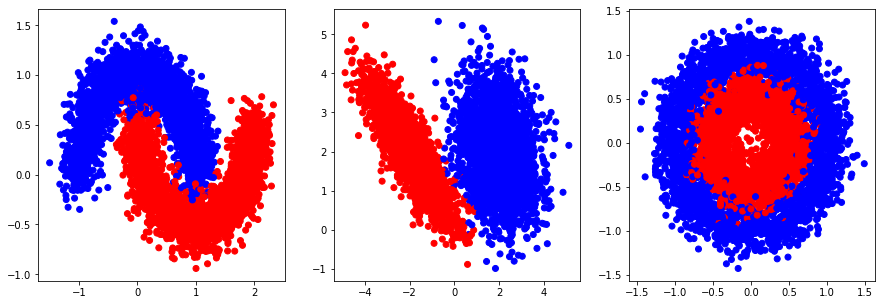

In [29]:
cm = ma.ListedColormap(['#0000FF', '#FF0000'])    # blue, red
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=cm)
plt.subplot(1,3,2)
plt.scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap=cm)
plt.subplot(1,3,3)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap=cm)

plt.show()

- Dummy

Este modelo representa el modelo aleatorio que predice la clase "prior" de los datasets y por tanto es considerado como el baseline para el resto de modelos. Cualquier modelo que definiéramos y cuyo rendimiento no superara el de este modelo se debe considerar como malo.

Los "accuracy" del modelo en cada dataset coinciden con los siguientes valores:

    Moons Dataset: 
    % Elementos clase 1 de la var. target en train:  50.175
    % Elementos clase 1 de la var. target en test:  49.3
    **********
    Linear Dataset: 
    % Elementos clase 1 de la var. target en train:  50.1
    % Elementos clase 1 de la var. target en test:  49.6
    **********
    Circles Dataset: 
    % Elementos clase 1 de la var. target en train:  50.175
    % Elementos clase 1 de la var. target en test:  49.3

#### "Moons" Dataset:

In [30]:
resultado_moons

,Classifier,accuracy_train,accuracy_CV_train,accuracy_validation,accuracy_test
0,Bagging,0.99125,0.990688,0.98875,0.988
1,RandomForest,0.99600,0.995625,0.98900,0.990
2,AdaBoost,0.99150,0.993063,0.98800,0.989
3,GradientBoosting,0.99875,0.999437,0.98950,0.990
4,XGBoost,0.99525,0.995875,0.98700,0.989
5,DT,0.99075,0.991063,0.98500,0.987
6,logisticRegression,0.87900,0.878500,0.87850,0.876
7,dummy,0.50175,0.501750,0.50175,0.493


- Bagging, RandomForest, AdaBoost, DT

Todos estos modelos, si se definen correctamente sus hiperparámetros, tienen capacidad suficiente para definir con precisión las fronteras entre los elementos de las dos clases aunque estas no sean lineales (en torno al 99% de "accuracy"). Considerando lo anterior, se pueden comprobar los resultados prácticamente perfectos de "accuracy" de éstos modelos. El mejor modelo obtenido para este dataset es "GradientBoostingClassifier" aunque con muy poca diferencia.

- Regresión logística

Este modelo obtiene un "accuracy" en torno al 87% en validación, esto se debe a la distribución de los elementos de las clases. A pesar de las formas curvas de la distribución, una gran mayoría de los elementos se pueden clasificar mediante una división lineal por lo que aunque este modelo nunca va a poder obtener resultados muy elevados, consigue un "accuracy" medio-alto.


    *** El mejor clasificador es:  GradientBoostingClassifier

#### "Linear" Dataset

In [31]:
resultado_linear

,Classifier,accuracy_train,accuracy_CV_train,accuracy_validation,accuracy_test
0,Bagging,0.99850,0.998937,0.99525,0.994
1,RandomForest,0.99825,1.000000,0.99475,0.995
2,AdaBoost,0.99850,0.999250,0.99600,0.995
3,GradientBoosting,1.00000,1.000000,0.99550,0.996
4,XGBoost,0.99625,0.997250,0.99550,0.994
5,DT,0.99725,0.997500,0.99450,0.990
6,logisticRegression,0.99575,0.995812,0.99600,0.994
7,dummy,0.50325,0.503250,0.50325,0.487


- Bagging, RandomForest, AdaBoost, DT, Regresión logística

Todos estos modelos, si se definen correctamente sus hiperparámetros, tienen capacidad suficiente para definir con precisión las fronteras entre los elementos de las dos clases. Considerando lo anterior, se puede comprobar los resultados muy altos de "accuracy" de éstos modelos (en torno al 99% de "accuracy"). El mejor modelo obtenido para este dataset es "AdaBoost" aunque con muy poca diferencia.

A diferencia del anterior dataset, en éste el modelo de regresión lineal consigue muy buenos resultados. Esto se debe a que la distribución de los elementos de cada clases tiene una dirección aproximadamente lineal y que ambas clases son fácilmente separables linealmente. 

    *** El mejor clasificador es:  AdaBoost

#### "Circles" Dataset

In [32]:
resultado_circles

,Classifier,accuracy_train,accuracy_CV_train,accuracy_validation,accuracy_test
0,Bagging,0.96900,0.967875,0.95450,0.940
1,RandomForest,0.97350,0.973312,0.95650,0.942
2,AdaBoost,0.95850,0.959313,0.95425,0.938
3,GradientBoosting,0.96875,0.968062,0.95575,0.946
4,XGBoost,0.96025,0.962125,0.95500,0.943
5,DT,0.96525,0.963500,0.94825,0.940
6,logisticRegression,0.50175,0.573750,0.56150,0.493
7,dummy,0.50175,0.501750,0.50175,0.493


- Bagging, RandomForest, AdaBoost, DT

Todos estos modelos, si se definen correctamente sus hiperparámetros, tienen capacidad suficiente para definir con precisión las fronteras entre los elementos de las dos clases aunque estas no sean lineales. A pesar de ello y dada la complejidad del dataset, ya que las fronteras entre los elementos de las dos clases son circunferencias y la definición de las mismas no es tan clara como en los modelos anteriores, se puede comprobar que los resultados de "accuracy" de éstos modelos pese a ser muy altos, no alcanzan los valores de los datsets anteriores. El mejor modelo obtenido para este dataset es "RandomForest" aunque con muy poca diferencia.

- Regresión logística

Este modelo obtiene un "accuracy" del 0.56150 en validación, un valor muy bajo y prácticamente similar al modelo aleatorio "dummy". Esto se debe a que las distribuciones de los elementos de las clases tienen forma de círculos concéntricos por lo que el dataset no es separable linealmente y por tanto de ahí el rendimiento tan bajo del modelo.

    *** El mejor clasificador es:  RandomForest
    
**_________________________________________________________________________**


### MISSING VALUES

El siguiente código modifica ligeramente el conjunto de datos de círculos para incorporar algunos missing values aleatorios.

In [33]:
from math import ceil

X_circles_missing = X_circles.copy()
y_circles_missing = y_circles.copy()

ids_v1 = np.random.choice(range(X_circles.shape[0]), size=ceil(0.05*X_circles.shape[0]), replace=False)
ids_v2 = np.random.choice(range(X_circles.shape[0]), size=ceil(0.1*X_circles.shape[0]), replace=False)

X_circles_missing[ids_v1,0] = np.nan
X_circles_missing[ids_v2,1] = np.nan

# volvemos a generar particion de train/test
X_circles_missing_train, X_circles_missing_test, y_circles_missing_train, y_circles_missing_test = train_test_split(X_circles_missing, y_circles_missing, test_size=0.20, random_state=314)


### AJUSTE DE HIPERPARÁMETROS (GridSearchCV)

### "Circles missing" Dataset:

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier



classifiers = {
    'Bagging': BaggingClassifier(random_state=1,n_jobs=-1),
    'RandomForest': RandomForestClassifier(criterion='gini', max_features='auto', bootstrap=True, oob_score=False, n_jobs=-1, random_state=1),
    'AdaBoost': AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', random_state=1),
    'GradientBoosting': GradientBoostingClassifier(loss='deviance',random_state=1,n_iter_no_change=None,tol=0.0001),
    'XGBoost': XGBClassifier(objective='binary:logistic', booster='gbtree', n_jobs=-1, random_state=1),
    'DT': DecisionTreeClassifier(random_state=1),
    'logisticRegression': LogisticRegression(random_state=1,solver='lbfgs'),
    'dummy': DummyClassifier(random_state=1,strategy='most_frequent')
}

params = {
            'Bagging':{
                'n_estimators':[30,40,45,50,55,70,80],
                'max_samples': [0.3,0.4,0.45,0.5,0.55,0.6,0.7]
                    },
            'RandomForest':{
                'n_estimators':[500,600,700],
                'max_depth':[11,12,13],
                'min_samples_split':[2,3,4,5],
                #'min_samples_leaf':[1,10,100],
                'max_samples': [0.4,0.5,0.6]
                    },
            'AdaBoost':{
                'n_estimators':[300,400,450,500,550,600,700],
                'learning_rate':[0.01,0.05,0.1,0.15,0.2]
                    },
            'GradientBoosting':{
                'learning_rate':[0.015,0.02],
                'n_estimators':[500,550],
                'subsample':[0.3,0.35],
                'min_samples_split':[200,250],
                #'min_samples_leaf':[12,14,16,18],   
                'max_depth':[10,15],                
                #'max_features':[0.1,0.25],
                #'validation_fraction':[0.1,0.15],
                #'n_iter_no_change':[10],               
                #'ccp_alpha': [0.0,0.5]
                    },
            'XGBoost':{
                'learning_rate':[0.05,0.1],
                'n_estimators':[1500,2000],
                'colsample_bytree':[0.001,0.01],
                'max_depth':[1,2,5], 
                'lambda':[0.0001,0.001],
                'alpha':[0.0001,0.001]
                    },
            'DT': {
                       'max_depth':[6,7,8,9,10,11,12], 
                       'min_samples_split':[20,30,35,40,45,50]
                    },
            'logisticRegression': {
                    'C':[0.0001,0.0005,0.001,0.0015,0.005,0.01,1]
                    },
            'dummy': {
                     }
         }

#######
# GRID SEARCH
#######

clf={}
for name in list(params.keys()):

    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(classifiers[name], params[name], 
                             scoring='accuracy', 
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
    clf[name].fit(X_circles_missing_train, y_circles_missing_train)

**********
Bagging
**********
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 242 out of 245 | elapsed:   12.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:   12.9s finished


ValueError: ignored

Al tratar de aplicar los modelos definidos al nuevo dataset nos devuelve un error y el código no se ejecuta. Ésto se debe a que el dataset contiene "missing values" y por tanto los datos son incompatibles con algunos de los modelos implementados en Scikit-Learn, que asumen que todos los valores de la matriz de datos son numéricos y que todos tienen un significado.

Tras revisar todos los modelos comprobamos que el único que acepta la introducción de "missing values" es "XGBoost".


In [46]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier


classifiers = {
    'XGBoost': XGBClassifier(objective='binary:logistic', booster='gbtree', n_jobs=-1, random_state=1),
    'dummy': DummyClassifier(random_state=1,strategy='most_frequent')
}

params = {
            'XGBoost':{
                'learning_rate':[0.05,0.1],
                'n_estimators':[1500,1600],
                'colsample_bytree':[0.001,0.01], 
                'max_depth':[1,2,5], 
                'lambda':[0.0001,0.001], 
                'alpha':[0.0001,0.001] 
                    },
            'dummy': {
                     }
         }

#######
# GRID SEARCH
#######

clf={}
for name in list(params.keys()):

    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(classifiers[name], params[name], 
                             scoring='accuracy', 
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
    clf[name].fit(X_circles_missing_train, y_circles_missing_train)

**********
XGBoost
**********
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 11.0min finished


**********
dummy
**********
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [47]:
#######
# BEST ESTIMATOR
#######

best_estims={}

for name in list(params.keys()):
    print("**********")
    print(name)
    print("**********")
    best_estims[name] = clf[name].best_estimator_
    print(best_estims[name])

**********
XGBoost
**********
XGBClassifier(alpha=0.0001, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.001,
              gamma=0, lambda=0.0001, learning_rate=0.05, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=None, n_estimators=1600,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)
**********
dummy
**********
DummyClassifier(constant=None, random_state=1, strategy='most_frequent')


In [48]:
from sklearn.metrics import accuracy_score

# compute results
test_scores = []

for name in list(params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(clf[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(clf[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]
    acc_cv_test = aux['mean_test_score']
    acc_cv_train = aux['mean_train_score']

    acc_train = accuracy_score(y_circles_missing_train, clf[name].predict(X_circles_missing_train))
    acc_test = accuracy_score(y_circles_missing_test, clf[name].predict(X_circles_missing_test))

    test_scores.append((name,acc_train,acc_cv_train,acc_cv_test,acc_test))
    
# mirar el rendimiento en validacion para obtener el mejor modelo
resultado_circles_missing = pd.DataFrame(test_scores,columns=['Classifier','accuracy_train','accuracy_CV_train','accuracy_validation','accuracy_test'])

display(resultado_circles_missing)

best_clas = resultado_circles_missing.sort_values(by="accuracy_validation",ascending=False).iloc[0]['Classifier']

print("*** El mejor clasificador es: ", best_clas)

XGBoost
Número de configuraciones:  96
dummy
Número de configuraciones:  1


,Classifier,accuracy_train,accuracy_CV_train,accuracy_validation,accuracy_test
0,XGBoost,0.92475,0.92675,0.91750,0.903
1,dummy,0.50175,0.50175,0.50175,0.493


*** El mejor clasificador es:  XGBoost



Para evitar este error habría que decidir entre eliminar dichos "missing values" o recurrir a alguna forma de imputación de los mismos (por el valor de la media, la mediana...).

**_________________________________________________________________________**


### IMPUTACIÓN DE MISSING VALUES Y AJUSTE DE HIPERPARÁMETROS

El siguiente código haría el ajuste de hiperparámetros considerando también un paso previo al clasificador en el que se imputan los missing values por media o mediana (la elección de media o mediana es otro parámetro a elegir). Para la imputación de missing values utilizaremos la función <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html">SimpleImputer</a> de scikit learn.

Lo bueno que nos ofrece scikit learn es que **podemos utilizar la función GridSearchCV sobre pipelines**. Fíjate en el código cómo se especifican en la instanciación del objeto GridSearchCV los hiperparámetros a ajustar en cada uno de los pasos del pipeline.

In [38]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


pl=Pipeline([
    ('imputer',SimpleImputer()),
    ('bagging',BaggingClassifier(random_state=1))
])

grid_n_estimators = [10,100]
grid_max_samples = [0.1,  0.5, 1.0]
grid_imputer_strategy = ["mean", "median"]

gs = GridSearchCV(estimator=pl,
                  param_grid={'imputer__strategy':grid_imputer_strategy,
                              'bagging__n_estimators': grid_n_estimators,
                              'bagging__max_samples': grid_max_samples},
                  cv=5,
                  verbose=1,
                  return_train_score=True,
                  )

gs.fit(X_circles_missing, y_circles_missing)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   17.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('bagging',
                                        BaggingClassifier(base_estimator=None,
                                                          bootstrap=True,
                                                          bootstrap_features=False,
                                                          max_features=1.0,
                                                          max_samples=1.0,
      

También podemos hacer predicciones sobre el modelo escogido por validación cruzada usando directamente la pipeline (¡que incluira todos los pasos anteriores al clasificador con los parámetros escogidos por validación cruzada!)

In [39]:
# El mejor estimador (best_estimator_) es una secuencia de pasos que se guarda como una lista de tuplas. 
# El primer elemento de la tupla se corresponde con el nombre del paso que hemos dado en el pipeline. 
# El segundo elemento de la tupla se corresponde con el objeto entrenado correspondiente a ese paso.
print(gs.best_estimator_.steps)

print("\n\n** Best parameters for the imputer (first step): ")
print(gs.best_estimator_.steps[0][0])
print(gs.best_estimator_.steps[0][1].get_params())

print("\n\n** Best parameters for the bagging classifier (second step): ")
print(gs.best_estimator_.steps[1][0])
print(gs.best_estimator_.steps[1][1].get_params())

[('imputer', SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)), ('bagging', BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=0.1, n_estimators=100,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False))]


** Best parameters for the imputer (first step): 
imputer
{'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}


** Best parameters for the bagging classifier (second step): 
bagging
{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.1, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


## Ejemplo real: predicción de morosidad 

Vamos ahora a aplicar todo lo aprendido sobre un conjunto de datos reales. Trabajaremos con una versión del conjunto de datos sobre impagos bancarios en Taiwan. Este conjunto de datos está públicamente disponible en <a href="https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients">UCI Machine Learning Repository</a>, pero el conjunto con el que trabajaremos ha sufrido alguna modificación, por lo que se usará en la práctica el fichero ./data/default_credit.csv.
En la página web de UCI se puede encontrar información sobre el dataset. En términos generales, consiste en un conjunto de datos en el que se trata de <b>predecir el impago de un cliente (variable 'X24_default payment next month')  en el mes siguiente al que se proveen los datos</b>. Cada fila (ejemplo/patrón) del dataframe representa un cliente y se dispone de las siguientes variables:

* **X1**: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* **X2**: Gender (male;female).
* **X3**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
    * Hay algunos otros valores de esta variable cuyo significado no está documentado.
* **X4**: Marital status (married;single;others).
* **X5**: Age (year).
* **X6 - X11**: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
    * <b>Valores -2 y 0</b> de estas variables están sin documentar en el <a href="https://www.sciencedirect.com/science/article/abs/pii/S0957417407006719">artículo original</a>, así que los consideraremos como categorías diferentes de las que no conocemos el significado.
* **X12-X17**: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* **X18-X23**: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 

El nombre de las variables es X_i seguido de un texto descriptivo de las variables.

El siguiente código carga el conjunto de datos como un dataframe de Pandas, y obtiene a partir de él dos dataframes:
* **df_y**: dataframe que contiene una columna con la variable objetivo.
* **df_X**: dataframe con el conjunto de variables independientes.


Al final del código se muestra el nombre de las variables independentes (predictores).

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
import pandas as pd

data = pd.read_csv("../data_in/default_credit.csv",sep=";")
#data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Practica_ENS/data_in/default_credit.csv",sep=";")

# Data frame que contiene unicamente la variable objetivo
df_y = data['X24_default payment next month']
# Numpy array que contiene unicamente la variable objetivo
y = df_y.values


# Data frame con las variables independientes (todas las variables menos la variable objetivo)
df_X = data.drop('X24_default payment next month',axis=1)
# Matriz numpy con las variables independientes
X = df_X.values

print(df_X.columns)

Index(['X1_LIMIT_BAL', 'X2_GENDER', 'X3_EDUCATION', 'X4_MARITAL_STATUS',
       'X5_AGE', 'X6_PAY_0', 'X7_PAY_2', 'X8_PAY_3', 'X9_PAY_4', 'X10_PAY_5',
       'X11_PAY_6', 'X12_BILL_AMT1', 'X13_BILL_AMT2', 'X14_BILL_AMT3',
       'X15_BILL_AMT4', 'X16_BILL_AMT5', 'X17_BILL_AMT6', 'X18_PAY_AMT1',
       'X19_PAY_AMT2', 'X20_PAY_AMT3', 'X21_PAY_AMT4', 'X22_PAY_AMT5',
       'X23_PAY_AMT6'],
      dtype='object')


En base a la definición de las variables y sus posibles valores, esta sería la clasificación entre variables continuas y categóricas:

* <b>Variables categóricas</b>: X2_GENDER, X3_EDUCATION, X4_MARITAL_STATUS y las variables X6-X11. X6-X11 podrían considerarse como categóricas ordinales.
* <b>Variables continuas</b>: Todas las demás

In [12]:
categorical_features = ['X2_GENDER', 'X3_EDUCATION', 'X4_MARITAL_STATUS',
                        'X6_PAY_0', 'X7_PAY_2', 'X8_PAY_3', 'X9_PAY_4', 'X10_PAY_5','X11_PAY_6']

continuous_features = list(set(df_X.columns)-set(categorical_features))

### ANÁLISIS DE VARIABLES

Puedes echar un vistazo a las características de las variables usando el paquete <a href="https://github.com/pandas-profiling/pandas-profiling">Pandas Profiling</a>. Para una configuración avanzada de pandas profiling, consultar <a href="https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/advanced_usage.html">este enlace</a>.

In [ ]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(data,      
                                         correlations={
                                             "pearson": {"calculate": True},
                                             "spearman": {"calculate": False},
                                             "kendall": {"calculate": False},
                                             "phi_k": {"calculate": False},
                                             "cramers": {"calculate": False},
                                         },
                                        interactions=None,
                                        missing_diagrams=None)
# para guardar resultado en html
profile.to_file("../data_out/Default_Credit.html")
profile

In [ ]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(data, title='Default_Credit_2', explorative=True)
# profile.to_notebook_iframe()
profile.to_file('../data_out/Default_Credit_2.html')

A partir del pandas profiling podemos sacar algunas conclusiones sobre los datos:
* <b>Análisis univariante de variables predictoras</b>: No se tienen missing values en las variables predictoras.
* <b>Análisis de variable target (X24)</b>: Se observa que el porcentaje de default es del 22.1%. Por tanto se trata de un problema desbalanceado.
* <b>Análisis multivariante (relaciones 2 a 2) de variables predictoras</b>: existen altas correlaciones (Pearson) entre algunos grupos de variables:
    * Correlaciones entre los recibos (X12-X17). Correlaciones muy altas entre las variables del grupo de importe de recibos. Cabe destacar que la correlación decrece a medida que los meses son más distantes. La menor correlación se da entre los meses de septiembre y abril.
    * Correlaciones positivas entre los aplazamiento de pagos (X6-X11). Correlaciones muy altas entre las variables del grupo de aplazamiento de pagos. Cabe destacar que la correlación decrece a medida que los meses son más distantes. La menor correlación se da entre los meses de septiembre y abril.
    * Correlaciones entre los pagos(X18-X23). No hay correlaciones destcables.
    * Correlación negativa entre el límite de crédito (X1) y los meses de aplazamientos de pago: a mayor límite de crédito menos meses de solicitud de aplazamiento. Tiene sentido porque es de preveer que la entidad bancaria conceda límites mayores a aquellos clientes que tenga un mejor perfil de pago.
* <b>Análisis de relación entre cada variable predictora y el target</b>: para las variables continuas lo podemos ver con la correlación de Pearson, para variables categóricas elaboraremos nuestro propio código (aunque en pandas profiling se puede configurar este análisis con el campo <code>interactions.targets</code>, la representación no es especialmente adecuada si lo que se quiere ver es la propensión a impago dado el valor de la variable predictora). El código de la siguiente celda sirve para analizar la relación entre el target y las diferentes variables categóricas.
    * <b>Educación (categórica)</b>: Se observa que a mayor nivel educativo, menor probabilidad de impago.
    * <b>Edad</b>: No se observa correlación significativa.
    * <b>Credit amount</b>: se observa una ligera correlación negativa. Esto tiene sentido porque es de esperar que la entidad bancaria conceda mayor límite a los clientes que se espera sean mejores pagadores.
    * <b>Aplazamiento de pagos(X6-X11)</b>: Se observa correlación positiva: si se aplazan significativamente los pagos es más probable el impago en el mes siguiente.

In [13]:
# EDUCATION (categorical)
import numpy as np

education = data.groupby(by="X3_EDUCATION",as_index=False).agg({'X24_default payment next month':np.mean})
education.rename(columns={'X24_default payment next month':'%_default'},inplace=True)
education['%_default'] = 100*education['%_default']
display(education)

,X3_EDUCATION,%_default
0,0,0.000000
1,1,19.234766
2,2,23.734854
3,3,25.157616
4,4,5.691057
5,5,6.428571
6,6,15.686275


<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
     Observar que pandas profiling no saca resultados de correlación para variables obviamente categóricas (<code>X4_MARITAL_STATUS</code>), pero sí lo saca para variables categóricas codificadas como numéricas (ejemplo: <code>X3_EDUCATION</code>). Sin embargo, aunque saque valores de correlación con <code>X3_EDUCATION</code>, estos no tienen sentido porque los valores de codificación no se corresponden con un orden semántico en la variable.
 </td></tr>
</table>

### Preprocesamiento de las variables categóricas
* No todos los algoritmos de aprendizaje supervisado pueden gestionar variables categóricas según se reciben en los datos "en bruto".
* Los árboles de decisión (y, por tanto, ensembles basados en árboles) sí pueden gestionar estas variables de forma adecuada considerando las distintas categorías a la hora de realizar los splits.
    * Sin embargo, la implementación de scikit learn no admite variables categóricas como por ejemplo X4_MARITAL_STATUS.
* Métodos como la regresión logística y las redes neuronales necesitan recibir siempre valores numéricos para que sus fundamentos teóricos tengan sentido.
<b>¡OJO!</b> Para que una variable sea considerada como categórica no implica que se defina como una cadena de texto. <code>X4_MARITAL_STATUS</code> es obvio que es una variable categórica con valores "single", "married" y "others". Pero la variable <code>X6_PAY_0</code>, aunque venga codificada con valores numéricos, también es una variable categórica y debe ser tratada como tal.
    * <b>¿Por qué?</b> Porque los valores numéricos no son realmente una variable continua. Por ejemplo, en el caso de la variable <code>X6_PAY_0</code> no tiene sentido que la distancia de pago total (-1) a aplazar el pago 1 mes sea la misma que la de aplazar el pago 1 mes a aplazar el pago 3 meses.
    * Hay que tener cuidado también en determinar si las categorías tienen un orden o no a la hora de aplicar un procesamiento u otro. Por ejemplo, "single", "married" y "others" está claro que no tienen un orden; pero si tuviéramos un problema de predecir el número de aprobados en una asignatura en base a las encuestas de calidad docente y una de las variables fuera la calificación general del profesor por parte de los estudiantes tomando valores "muy negativo", "negativo", "neutro", "positivo", "muy positivo", está claro que aquí las categorías sí tienen un orden.

#### ¿Cómo procesamos las variables categóricas?

* Existen muchos métodos para procesar variables categóricas. En el paquete <a href="https://contrib.scikit-learn.org/category_encoders/">category_encoders</a> hay muchos métodos implementados.

* En este notebook, utilizaremos el método de **target encoder**. En el caso de problemas de clasificación binaria, el método de target encoder reemplaza con una media ponderada de la probabilidad de ver el target 1 cuando la variable toma cierta categoría y la probabilidad del target sobre todo el dataset (prior). Para más detalles, ver <a href="https://dl.acm.org/doi/10.1145/507533.507538">este artículo</a>.
    * Se suele utilizar cuando la variable categórica tiene muy alta dimensionalidad. Tiene la ventaja de que no aumenta la dimensionalidad del dataset, pero el inconveniente de que la variable deja de ser fácilmente interpretable ya que es sustituida por un valor continuo.
    * Se encuentra implementado en <a href="https://contrib.scikit-learn.org/category_encoders/targetencoder.html">category_encoders</a>.
        * El peso de la prior de la clase positiva en el dataset global respecto a la prior de la clase positiva en cada categoría se especifica mediante el parámetro <code>smoothing</code>.
        * Para que la prior de la categoría sea tenida en cuenta en la media ponderada debe tener un mínimo número de muestras especificadas en el parámetro <code>min_samples_leaf</code>.

Notar las diferencias entre target encoder, y el método más comúnmente utilizado de <b>one-hot-encoder</b> (variables dummy) en el que se produce una variable binaria por cada categoría. Básicamente es un indicador de si la variable es de cierta categoría o no. Por ejemplo, en el caso de <code>X4_MARITAL_STATUS</code> se sustituiría esta variable por 3 nuevas variables binarias <code>X4_MARITAL_STATUS_single</code>, <code>X4_MARITAL_STATUS_married</code>, y <code>X4_MARITAL_STATUS_others</code>.
   * Se suele utilizar cuando hay pocas categorías. Es intuitivo, las variables generadas son fácilmente interpretables, pero tiene el incoveniente de que aumenta la dimensionalidad del dataset.
   * Se encuentra implementado en <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">Scikit-Learn</a>.
    
    
### Imputación de missing values

La imputación de missing values es un campo de investigación en sí mismo dentro del mundo del Machine Learning. Aunque hay métodos que admiten los missing values de forma natural (por ejemplo, los árboles de decisión), en general se suelen tratar para hacer los datos compatibles con cualquier algoritmo de aprendizaje.

Existe la posibilidad de eliminar aquellos patrones que contengan missing values. Esto es posible si representan un porcentaje realmente pequeño del conjunto de datos, pero, en general, no es deseable eliminar patrones. En su lugar, se suelen reemplazar los missing values por ciertos valores calculados a partir de los datos. Los métodos para calcular los valores con los que imputar los missing values pueden ser muy diversos (desde una simple media/mediana hasta imputar el valor que tome el vecino más próximo). Algunas técnicas comúnmente utilizadas e implementadas en la clase <a href="https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html">Imputer</a> de  Scikit-learn.
* <b>Variables continuas</b>. Los missing values se imputarán con la media o mediana (a determinar dentro del grid de búsqueda de hiperparámetros).
* <b>Variables categóricas</b>. Se imputarán con el valor más común (la moda).
    * <b>¡OJO!</b> es importante realizar la imputación antes de la codificación.
    
<b>En este problema particular no hay missing values como se puede ver en el pandas profiling, por tanto no aplicaremos este paso en el preprocesamiento de datos</b>.

### Escalado de variables
Como se ha visto en la parte teórica, algunos métodos como las redes neuronales o la regresión logística (según el tipo de solver a utilizar) necesitan de un escalado de datos para garantizar una mejor convergencia de los algoritmos. Otros métodos como vecinos próximos también requieren de este escalado para garantizar que todas las variables toman la misma importancia. Por otra parte, métodos basados en árboles de decisión son "inmunes" a este tipo de transformación. De cara a garantizar que todos los algoritmos de clasificación "compiten" en las mismas condiciones, se van a escalar las <b>variables continuas</b> utilizando un escalado estándar (media 0 y desviación típica 1) para cada una de la variables. Para ello se utilizará la clase <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> de Scikit-Learn. No obstante, existen otras técnicas de escalado, algunas implementadas en Scikit Learn como <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html">RobustScaler</a> o <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a>.

Para <b>variables categóricas</b> hay que determinar si el escalado tiene sentido. Por ejemplo, si aplicamos un one-hot-encoder no lo tiene y en el caso de target encoder podría tenerlo al ser una variable continua, pero sabemos que está en el rango $[0,1)$, así que tampoco aplicaremos escalado.

### ANÁLISIS DE LA VARIABLE TARGET

    df_y: dataframe que contiene una columna con la variable objetivo.
    df_X: dataframe con el conjunto de variables independientes.

Analizamos los valores tomados por la var. target:

In [14]:
df_y.value_counts()

0    23364
1     6636
Name: X24_default payment next month, dtype: int64

Dado que la var. target es de tipo binario (toma valores 1 ó 0) y que la clase positiva (ocurrencia del suceso estudiado "default") está representada por el valor 1, para calcular el porcentaje de patrones de la var. target pertenecientes a dicha clase basta con calcular la media de la var. target.

In [15]:
df_y.mean()

0.2212

El porcentaje de ejemplos de la var. target que pertenecen a la clase positiva (valor 1) es del 22,12%.

Las métricas a emplear dependen del tipo de problema así como de ciertos condicionantes del mismo, entre ellos está el análisis de la distribución de la variable target. En el caso que nos ocupa estamos ante un problema de clasificación (binario, 2 clases) por lo que en términos generales podríamos utilizar métricas como el "accuracy", la curva ROC-AUC (área bajo la curva), la curva lift o tablas de Precision-Recall.

De todas formas y como comentábamos al inicio, existen ciertos condicionantes de cara al uso de ciertas métricas en función del problema estudiado. Si los datos están balanceados podemos emplear cualquiera de las métricas asociadas al tipo de problema que estamos estudiando, en cambio si los datos están desbalanceados, como hemos comprobado con anterioridad, hay algunas métricas que no se van a poder utilizar como es el caso del "accuracy" ya que no permite analizar con claridad el rendimiento del modelo.

Por ello la métrica que se va a utilizar el la del ROC-AUC (área bajo la curva) que nos dará un valor entre 0 y 1, que nos servirá para analizar el rendimiento del modelo considerando:

- Modelo perfecto_ AUC=1  (es decir "Specificity"=1 y "False Positive Rate"=0)
- Modelo aleatorio_ AUC=0.5 (sea cual sea el desbalanceo de los datos)

Para obtenerla se va desplazando el umbral de decisión y sacando para cada umbral el punto de la gráfica según su coordenada x: "FALSE POSITIVE RATE" (1-SPECIFICITY, % negativos he fallado sobre todos los que tenía que acertar) y su coordenada y: "SPECIFICITY" (% negativos he acertado sobre el total de negativos que tenía que acertar).

En lo que sigue usaremos el **área bajo la curva ROC (AUC)** para medir el rendimiento del modelo.

### SUBCONJUNTOS DE DATOS (TRAIN & TEST)

Realizamos una partición aleatoria de training y test de los datos, para luego usar ColumnTransformer. Usaremos una partición hold-out estratificada en la que el 80% de los datos se usarán para entrenamiento (y validación) y el 20% de datos restantes para test. 

In [16]:
print(df_X.shape)
print(df_y.shape)

(30000, 23)
(30000,)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, train_size=0.8, \
                                                    random_state=314, shuffle=True,stratify=df_y)

Revisamos que hemos realizado las particiones "train" y "test" de forma correcta comprobando las dimensiones de los dataframes obtenidos.

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24000, 23)
(6000, 23)
(24000,)
(6000,)


La partición en conjuntos de training y test en este caso es "sencilla" puesto que no disponemos de información temporal y solo tenemos un registro por cliente. En una caso más realista habría que analizar este punto con cuidado.

### AJUSTE DE HIPERPARÁMETROS

Determinaremos el mejor pipeline e hiperparámetros utilizando validación cruzada estratificada con 5 folds, teniendo en cuenta que el problema tiene tanto variables categóricas como continuas. Probaremos los 5 clasificadores ensembles con los que venimos trabajando (bagging, Random Forest, AdaBoost, Gradient Boosting Trees, y XGBoost), así como la regresión logística y el árbol de decisión.

Aplicaremos el pre-procesamiento necesario a aquellas variables categóricas que lo necesiten, utilizando el método de target encoder. El método VarianceThreshold de sklearn sirve para eliminar variables constantes (varianza = 0).


``` python

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold



continuous_pipeline = Pipeline([
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('codification', TargetEncoder(cols=categorical_features))
])

preprocessing_pipeline = ColumnTransformer([
        ('continuous', continuous_pipeline, continuous_features),
        ('categorical', categorical_pipeline, categorical_features)
    ],
    remainder = 'drop' 
)

pipeline = Pipeline([
    ('preprocess', preprocessing_pipeline),
    ('feature_selection', VarianceThreshold(threshold=0.0)),
    ('classifier', LogisticRegression(max_iter=1000))])
```

Y el siguiente código serviría para configurar, por ejemplo, la búsqueda para el dummy classifier.

```python
params = {
            'dummy': {'preprocess__categorical__codification__smoothing':[1.0, 10.0, 25.0, 50.0, 100.0],
                   'preprocess__categorical__codification__min_samples_leaf':[100,200,300,400,500],
                    'classifier': [DummyClassifier(random_state=1,strategy='most_frequent')]}
         }
```

Definimos el pipeline genérico, que incluye el preprocesado de las variables predictoras y la variable "classifier" que representa el modelo a aplicar, y las mallas para la búsqueda de hiperparámetros en los distintos modelos:

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

continuous_pipeline = Pipeline([ ('scale', StandardScaler()) ])

categorical_pipeline = Pipeline([ ('codification', TargetEncoder(cols=categorical_features)) ])

preprocessing_pipeline = ColumnTransformer([
        ('continuous', continuous_pipeline, continuous_features),
        ('categorical', categorical_pipeline, categorical_features)
    ],
    remainder = 'drop' 
)

classif_params = {
             'Bagging': {'preprocess__categorical__codification__smoothing':[50.0,70.0],
                         #'preprocess__categorical__codification__min_samples_leaf':[600,800],
                         'classifier__n_estimators':[600,800],
                         #'classifier__max_samples': [0.15,0.20],
                         'classifier': BaggingClassifier(random_state=1,n_jobs=-1)},
    
             'RandomForest': {'preprocess__categorical__codification__smoothing':[85.0,90.0],
                              'preprocess__categorical__codification__min_samples_leaf':[800,850],
                              'classifier__n_estimators':[650,700],
                              'classifier__max_depth':[40,45],
                              'classifier__min_samples_split':[200,250],
                              #'classifier__min_samples_leaf':[1,10,100],
                              'classifier__max_samples': [0.9,0.95],
                              'classifier': RandomForestClassifier(criterion='gini', max_features='auto', bootstrap=True, 
                                                                   oob_score=False, n_jobs=-1, random_state=1)},  
    
             'AdaBoost': {'preprocess__categorical__codification__smoothing':[65.0,70.0,75.0],
                          'preprocess__categorical__codification__min_samples_leaf':[40,45,50],
                          'classifier__n_estimators':[200,250,300],
                          'classifier__learning_rate':[0.05,0.1,0.15],
                          'classifier': AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', random_state=1)},
    
             'GradientBoosting': {'preprocess__categorical__codification__smoothing':[60.0], #60.0,65.0
                                  'preprocess__categorical__codification__min_samples_leaf':[100], #100,150
                                  'classifier__learning_rate':[0.005], #0.005,0.01
                                  'classifier__n_estimators':[950], #950,1000
                                  'classifier__subsample':[0.65], #0.65,0.7
                                  'classifier__min_samples_split':[400], #350,400
                                  'classifier__max_depth':[8], #7,8
                                  'classifier': GradientBoostingClassifier(loss='deviance',random_state=1,max_features='sqrt',
                                                                           n_iter_no_change=None,tol=0.0001)},
    
             'XGBoost': {'preprocess__categorical__codification__smoothing':[50.0,70.0],
                         'preprocess__categorical__codification__min_samples_leaf':[100], #100,150
                         'classifier__learning_rate':[0.05,0.1], #0.05,0.1
                         'classifier__n_estimators':[100], #50,100
                         'classifier__colsample_bytree':[0.01,1],
                         'classifier__max_depth':[5], #5,6
                         'classifier__reg_lambda':[0.1,1],
                         'classifier__reg_alpha':[0.1,1],
                         'classifier': XGBClassifier(objective='binary:logistic', booster='gbtree', 
                                                     disable_default_eval_metric=True, n_jobs=-1, random_state=1)}, 
    
            'logisticRegression': {'preprocess__categorical__codification__smoothing':[95.0,100.0],
                                   'preprocess__categorical__codification__min_samples_leaf':[1,3,5,7,10],
                                   'classifier__C':[1,3,5,7,10],
                                   'classifier': LogisticRegression(random_state=1,solver='lbfgs')},  
    
            'DT': {'preprocess__categorical__codification__smoothing':[35.0,40.0,45.0],
                   'preprocess__categorical__codification__min_samples_leaf':[750,800,850],
                   'classifier__max_depth':[13,14,15], 
                   'classifier__min_samples_split':[800,850,900],
                   'classifier': DecisionTreeClassifier(random_state=1)},
         }

#### 1ª OPCIÓN - BÚSQUEDA HIPERPARÁMETROS: 
Definimon una función "GridSearchCV" conjunto para todos los modelos (bucle automático).

In [ ]:
#######
# GRID SEARCH
#######

clf={}

for name in list(classif_params.keys()):
    
    params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
    classifier = classif_params[name]['classifier']
    
    pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
    ])

    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(pipeline, params, 
                             scoring='roc_auc',
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
    clf[name].fit(X_train, y_train)

**********
Bagging
**********
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**********
RandomForest
**********
Fitting 5 folds for each of 64 candidates, totalling 320 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**********
AdaBoost
**********
Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**********
GradientBoosting
**********
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**********
XGBoost
**********
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


**********
logisticRegression
**********
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**********
DT
**********
Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
#######
# BEST ESTIMATOR
#######

best_estims={}

for name in list(classif_params.keys()):
    print("**********")
    print(name)
    print("**********")
    best_estims[name] = clf[name].best_estimator_
    print(best_estims[name])

**********
Bagging
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['X15_BILL_AMT4',
                                                   'X22_PAY_AMT5',
                                                   'X20_PAY_AMT3',
                                                   'X19_PAY_AMT2',
                                                   'X18_PAY_AMT1',
                                                   'X14_BILL_AMT3', 'X5_AGE',
                                                   'X1_LIMIT_BAL',
                                                   'X12_BILL_AMT1',
                                                   'X16_BILL_AMT5',
                                                   'X23_PAY_AMT6',
                           

#### 2ª OPCIÓN - BÚSQUEDA HIPERPARÁMETROS: 
Definimon funciones "GridSearchCV" independientes para cada uno de los modelos (más útil para el ajuste individual de cada modelo).

In [23]:
#######
# GRID SEARCH (Results dictionary)
#######

clf={}

In [24]:
# MODELO: 'Bagging'

name = 'Bagging'

params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
classifier = classif_params[name]['classifier']

pipeline = Pipeline([
    ('preprocess', preprocessing_pipeline),
    ('feature_selection', VarianceThreshold(threshold=0.0)),
    ('classifier', classifier)
])

print("**********")
print(name)
print("**********")

clf[name] = GridSearchCV(pipeline, params, 
                         scoring='roc_auc',
                         return_train_score=True, 
                         n_jobs=-1, cv=5, verbose=2)
clf[name].fit(X_train, y_train)

**********
Bagging
**********
Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

In [ ]:
clf[RandomForest].cv_results_

In [ ]:
# MODELO: 'RandomForest'

name = 'RandomForest'

params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
classifier = classif_params[name]['classifier']
    
pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
])

print("**********")
print(name)
print("**********")
clf[name] = GridSearchCV(pipeline, params, 
                             scoring='roc_auc',
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
clf[name].fit(X_train, y_train)

**********
RandomForest
**********
Fitting 5 folds for each of 64 candidates, totalling 320 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['X15_BILL_AMT4',
                                                                          'X22_PAY_AMT5',
                                                                          'X20_PAY_AMT3',
                                                                          'X19_PAY_AMT2',
                                                                          'X18_PAY_AMT1',
                                                                          'X14_BILL_AMT3',
                                                                          'X5_AGE',
    

In [ ]:
# MODELO: 'AdaBoost'

name = 'AdaBoost'

params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
classifier = classif_params[name]['classifier']
    
pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
])

print("**********")
print(name)
print("**********")
clf[name] = GridSearchCV(pipeline, params, 
                             scoring='roc_auc',
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
clf[name].fit(X_train, y_train)

**********
AdaBoost
**********
Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['X15_BILL_AMT4',
                                                                          'X22_PAY_AMT5',
                                                                          'X20_PAY_AMT3',
                                                                          'X19_PAY_AMT2',
                                                                          'X18_PAY_AMT1',
                                                                          'X14_BILL_AMT3',
                                                                          'X5_AGE',
    

In [ ]:
# MODELO: 'Gradient (Tree) Boosting'

name = 'GradientBoosting'

params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
classifier = classif_params[name]['classifier']
    
pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
])

print("**********")
print(name)
print("**********")
clf[name] = GridSearchCV(pipeline, params, 
                             scoring='roc_auc',
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
clf[name].fit(X_train, y_train)

**********
GradientBoosting
**********
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['X15_BILL_AMT4',
                                                                          'X22_PAY_AMT5',
                                                                          'X20_PAY_AMT3',
                                                                          'X19_PAY_AMT2',
                                                                          'X18_PAY_AMT1',
                                                                          'X14_BILL_AMT3',
                                                                          'X5_AGE',
    

In [ ]:
# MODELO: 'XGBoost'

name = 'XGBoost'

params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
classifier = classif_params[name]['classifier']
    
pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
])

print("**********")
print(name)
print("**********")
clf[name] = GridSearchCV(pipeline, params, 
                             scoring='roc_auc',
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
clf[name].fit(X_train, y_train)

**********
XGBoost
**********
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['X15_BILL_AMT4',
                                                                          'X22_PAY_AMT5',
                                                                          'X20_PAY_AMT3',
                                                                          'X19_PAY_AMT2',
                                                                          'X18_PAY_AMT1',
                                                                          'X14_BILL_AMT3',
                                                                          'X5_AGE',
    

In [ ]:
# MODELO: 'Logistic Regression'

name = 'logisticRegression'

params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
classifier = classif_params[name]['classifier']
    
pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
])

print("**********")
print(name)
print("**********")
clf[name] = GridSearchCV(pipeline, params, 
                             scoring='roc_auc',
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
clf[name].fit(X_train, y_train)

**********
logisticRegression
**********
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['X15_BILL_AMT4',
                                                                          'X22_PAY_AMT5',
                                                                          'X20_PAY_AMT3',
                                                                          'X19_PAY_AMT2',
                                                                          'X18_PAY_AMT1',
                                                                          'X14_BILL_AMT3',
                                                                          'X5_AGE',
    

In [ ]:
# MODELO: 'DT (Decission Tree)'

name = 'DT'

params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
classifier = classif_params[name]['classifier']
    
pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
])

print("**********")
print(name)
print("**********")
clf[name] = GridSearchCV(pipeline, params, 
                             scoring='roc_auc',
                             return_train_score=True, 
                             n_jobs=-1, cv=5, verbose=2)
clf[name].fit(X_train, y_train)

**********
DT
**********
Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['X15_BILL_AMT4',
                                                                          'X22_PAY_AMT5',
                                                                          'X20_PAY_AMT3',
                                                                          'X19_PAY_AMT2',
                                                                          'X18_PAY_AMT1',
                                                                          'X14_BILL_AMT3',
                                                                          'X5_AGE',
    

In [ ]:
#######
# BEST ESTIMATOR
#######

best_estims={}

for name in list(classif_params.keys()):
    print("**********")
    print(name)
    print("**********")
    best_estims[name] = clf[name].best_estimator_
    print(best_estims[name])

**********
Bagging
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['X15_BILL_AMT4',
                                                   'X22_PAY_AMT5',
                                                   'X20_PAY_AMT3',
                                                   'X19_PAY_AMT2',
                                                   'X18_PAY_AMT1',
                                                   'X14_BILL_AMT3', 'X5_AGE',
                                                   'X1_LIMIT_BAL',
                                                   'X12_BILL_AMT1',
                                                   'X16_BILL_AMT5',
                                                   'X23_PAY_AMT6',
                           

logisticRegression
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['X15_BILL_AMT4',
                                                   'X22_PAY_AMT5',
                                                   'X20_PAY_AMT3',
                                                   'X19_PAY_AMT2',
                                                   'X18_PAY_AMT1',
                                                   'X14_BILL_AMT3', 'X5_AGE',
                                                   'X1_LIMIT_BAL',
                                                   'X12_BILL_AMT1',
                                                   'X16_BILL_AMT5',
                                                   'X23_PAY_AMT6',
                           

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td><b>[1 punto]</b> Obten los rendimientos sobre los conjuntos de entrenamiento, validación y test del mejor modelo para cada tipo de clasificador. Recuerda que los rendimiento s de entrenamiento y validación los tienes en las variables <code>mean_train_score</code> y <code>mean_test_score</code>  de la tabla de resultados de GridSearchCV, respectivamente. ¿Se parecen los resultados de test a los resultados de entrenamiento y validación? ¿Está el clasificador incurriendo en underfitting/overfitting? Muestra en una celda la tabla con los resultados obtenidos con las siguientes columnas: Classifier, AUC_train, AUC_CV_train, AUC_validation, AUC_test.</td></tr>
</table>

Obtenemos los distintos rendiemientos en entrenamiento y test para cada uno de los modelos. Recogemos los resultados de forma conjunta en una tabla explicativa para su posterior análisis.

In [ ]:
from sklearn.metrics import roc_auc_score

# compute results
test_scores = []

for name in list(classif_params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(clf[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(clf[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]
    RocAuc_cv_test = aux['mean_test_score']
    RocAuc_cv_train = aux['mean_train_score']
    
    RocAuc_train = roc_auc_score(y_train, clf[name].predict(X_train))
    RocAuc_test = roc_auc_score(y_test, clf[name].predict(X_test))

    test_scores.append((name,RocAuc_train,RocAuc_cv_train,RocAuc_cv_test,RocAuc_test))
    
# mirar el rendimiento en validacion para obtener el mejor modelo
resultado = pd.DataFrame(test_scores,columns=['Classifier','RocAuc_train','RocAuc_CV_train','RocAuc_validation','RocAuc_test'])

display(resultado)

best_clas = resultado.sort_values(by="RocAuc_validation",ascending=False).iloc[0]['Classifier']

print("*** El mejor clasificador es: ", best_clas)

Bagging
Número de configuraciones:  16
RandomForest
Número de configuraciones:  64
AdaBoost
Número de configuraciones:  81
GradientBoosting
Número de configuraciones:  1
XGBoost
Número de configuraciones:  32
logisticRegression
Número de configuraciones:  50
DT
Número de configuraciones:  81


,Classifier,RocAuc_train,RocAuc_CV_train,RocAuc_validation,RocAuc_test
0,Bagging,0.708453,0.925310,0.776509,0.672819
1,RandomForest,0.664542,0.852312,0.782855,0.673950
2,AdaBoost,0.644541,0.785370,0.775655,0.659018
3,GradientBoosting,0.671425,0.838256,0.785262,0.670447
4,XGBoost,0.670560,0.827606,0.783084,0.667265
5,logisticRegression,0.648841,0.767885,0.766118,0.663976
6,DT,0.657330,0.792282,0.765007,0.665176


*** El mejor clasificador es:  GradientBoosting


En general para todos los modelos estudiados, los rendimientos obtenidos en test son similares a los de entrenamiento (con pequeñas variaciones) pero inferiores a los rendimientos obtenidos para los subconjuntos de train y validation en el "cross-validation".

Además como se puede observar, dado que los rendimientos de los modelos son mayores en entrenamiento estamos ante casos de "overfitting".


Otros aspectos a tener en cuenta son:

- El modelo con rendimientos más equilibrados, con menor "overfitting", es el "LogisticRegression".

- Los modelo que obtienen los mejores rendimientos en validación son: "RandomForest", "GradientBoosting" y "XGBoost", siendo "GradientBoosting" el mejor de todos.

### ANÁLISIS DE MÉTRICAS

El mejor modelo obtenido es un ensemble de tipo 'Gradient (Tree) Boosting' con los parámetros recogidos a continuación:

In [ ]:
#######
# BEST ESTIMATOR
#######

name = 'GradientBoosting'

print("**********")
print(name)
print("**********")
best_estims[name] = clf[name].best_estimator_
print(best_estims[name])

**********
GradientBoosting
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['X15_BILL_AMT4',
                                                   'X22_PAY_AMT5',
                                                   'X20_PAY_AMT3',
                                                   'X19_PAY_AMT2',
                                                   'X18_PAY_AMT1',
                                                   'X14_BILL_AMT3', 'X5_AGE',
                                                   'X1_LIMIT_BAL',
                                                   'X12_BILL_AMT1',
                                                   'X16_BILL_AMT5',
                                                   'X23_PAY_AMT6',
                  




**________________________**

A modo de ejemplo, el siguiente código obtiene los resultados utilizando una regresión logística sin hacer ajuste de hiperparámetros.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression


continuous_pipeline_lr = Pipeline([
    ('scale', StandardScaler())
])

categorical_pipeline_lr = Pipeline([
    ('codification', TargetEncoder(cols=categorical_features))
])

preprocessing_pipeline_lr = ColumnTransformer([
        ('continuous', continuous_pipeline_lr, continuous_features),
        ('categorical', categorical_pipeline_lr, categorical_features)
    ],
    remainder = 'drop' 
)

pipeline_lr = Pipeline([
    ('preprocess', preprocessing_pipeline_lr),
    ('feature_selection', VarianceThreshold(threshold=0.0)),
    ('classifier', LogisticRegression(max_iter=1000))])

_=pipeline_lr.fit(X_train,y_train)

C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Calculemos una tabla básica de rendimientos del modelo de riesgo de crédito sobre esta regresión logística.

In [ ]:
# a mayor score, mayor riesgo
preds_lr = pipeline_lr.predict_proba(X_test)[:,1]

aux = pd.DataFrame(np.c_[preds_lr,y_test.values],columns=['score','target'])
aux['rango'] = pd.qcut(aux['score'],10)
tabla = aux.groupby(by="rango",as_index=False).agg({'target':[len,sum,np.mean]})
tabla.columns = tabla.columns.droplevel()
tabla.columns = ['rango','n_clientes','n_default','default_rate']
tabla['default_rate'] = 100*tabla['default_rate']
tabla['acum_clientes'] = pd.DataFrame.cumsum(tabla['n_clientes'])
tabla['acum_target'] = pd.DataFrame.cumsum(tabla['n_default'])
tabla['default_IN'] = 100*tabla['acum_target']/tabla['acum_clientes']
tabla['default_OUT'] = 100*((tabla['n_default'].sum()-tabla['acum_target'])/(tabla['n_clientes'].sum()-tabla['acum_clientes']))
tabla['recall'] = 100*(tabla['acum_target']/tabla['n_default'].sum())
tabla['aceptacion'] = 100*(tabla['acum_clientes']/tabla['n_clientes'].sum())
tabla

,rango,n_clientes,n_default,default_rate,acum_clientes,acum_target,default_IN,default_OUT,recall,aceptacion
0,"(-0.00099999999672, 0.0942]",600.0,40.0,6.666667,600.0,40.0,6.666667,23.833333,3.014318,10.0
1,"(0.0942, 0.115]",600.0,45.0,7.500000,1200.0,85.0,7.083333,25.875000,6.405426,20.0
2,"(0.115, 0.129]",600.0,77.0,12.833333,1800.0,162.0,9.000000,27.738095,12.207988,30.0
3,"(0.129, 0.139]",600.0,74.0,12.333333,2400.0,236.0,9.833333,30.305556,17.784476,40.0
4,"(0.139, 0.149]",600.0,80.0,13.333333,3000.0,316.0,10.533333,33.700000,23.813112,50.0
5,"(0.149, 0.162]",600.0,96.0,16.000000,3600.0,412.0,11.444444,38.125000,31.047476,60.0
6,"(0.162, 0.184]",600.0,103.0,17.166667,4200.0,515.0,12.261905,45.111111,38.809344,70.0
7,"(0.184, 0.257]",600.0,133.0,22.166667,4800.0,648.0,13.500000,56.583333,48.831952,80.0
8,"(0.257, 0.554]",600.0,243.0,40.500000,5400.0,891.0,16.500000,72.666667,67.143934,90.0
9,"(0.554, 0.94]",600.0,436.0,72.666667,6000.0,1327.0,22.116667,NaN,100.000000,100.0


Como hemos visto con anterioridad, el modelo de regresión logística tiene un rendimiento mayor que el modelo aleatorio a la hora de clasificar los casos de "default" en el problema de riesgo de crédito planteado.

La aplicación al problema de riesgo de crédito del modelo de regresión logística es claramente mejor que no utilizar modelo. 

Frente a no utilizar modelo o utilizar el modelo aleatorio (que considera sólo la probabilidad del prior de la variable target para toda la población, independientemente de la muestra de la misma que seleccionemos), el modelo de regresión logística definido permite clasificar a diferentes subconjuntos de la población en rangos según sus probabilidades de "default".

Esto nos permite ser mucho más precisos a la hora de considerar las probabilidades de "default" en los diferentes subconjuntos de la población definidos (mayor porcentaje de acierto en los casos de "default") y poder ajustar de forma más precisa las decisiones de negocio para cada uno de los grupos de clientes.

### TABLA DE RENDIMIENTOS

In [ ]:
#######
# TABLA DE RENDIMIENTOS (Modelo: 'GradientBoosting')
#######

name = 'GradientBoosting'

preds = clf[name].predict_proba(X_test)[:,1]

aux = pd.DataFrame(np.c_[preds,y_test.values],columns=['score','target'])
aux['rango'] = pd.qcut(aux['score'],10)
tabla = aux.groupby(by="rango",as_index=False).agg({'target':[len,sum,np.mean]})
tabla.columns = tabla.columns.droplevel()
tabla.columns = ['rango','n_clientes','n_default','default_rate']
tabla['default_rate'] = 100*tabla['default_rate']
tabla['acum_clientes'] = pd.DataFrame.cumsum(tabla['n_clientes'])
tabla['acum_target'] = pd.DataFrame.cumsum(tabla['n_default'])
tabla['default_IN'] = 100*tabla['acum_target']/tabla['acum_clientes']
tabla['default_OUT'] = 100*((tabla['n_default'].sum()-tabla['acum_target'])/(tabla['n_clientes'].sum()-tabla['acum_clientes']))
tabla['recall'] = 100*(tabla['acum_target']/tabla['n_default'].sum())
tabla['aceptacion'] = 100*(tabla['acum_clientes']/tabla['n_clientes'].sum())
tabla

,rango,n_clientes,n_default,default_rate,acum_clientes,acum_target,default_IN,default_OUT,recall,aceptacion
0,"(0.0294, 0.0665]",600.0,27.0,4.500000,600.0,27.0,4.500000,24.074074,2.034665,10.0
1,"(0.0665, 0.0837]",600.0,36.0,6.000000,1200.0,63.0,5.250000,26.333333,4.747551,20.0
2,"(0.0837, 0.101]",600.0,54.0,9.000000,1800.0,117.0,6.500000,28.809524,8.816880,30.0
3,"(0.101, 0.12]",600.0,80.0,13.333333,2400.0,197.0,8.208333,31.388889,14.845516,40.0
4,"(0.12, 0.142]",600.0,78.0,13.000000,3000.0,275.0,9.166667,35.066667,20.723436,50.0
5,"(0.142, 0.169]",600.0,106.0,17.666667,3600.0,381.0,10.583333,39.416667,28.711379,60.0
6,"(0.169, 0.216]",600.0,110.0,18.333333,4200.0,491.0,11.690476,46.444444,37.000754,70.0
7,"(0.216, 0.331]",600.0,139.0,23.166667,4800.0,630.0,13.125000,58.083333,47.475509,80.0
8,"(0.331, 0.567]",600.0,252.0,42.000000,5400.0,882.0,16.333333,74.166667,66.465712,90.0
9,"(0.567, 0.89]",600.0,445.0,74.166667,6000.0,1327.0,22.116667,NaN,100.000000,100.0


Como hemos visto con anterioridad, el modelo modelo de GradientBoosting tiene un rendimiento mayor que los modelos aleatorio y de regresión logística a la hora de clasificar los casos de "default" en el problema de riesgo de crédito planteado.

El modelo de GradientBoosting definido permite clasificar de forma más precisa los casos de "default" en el problema de riesgo de crédito planteado que el modelo de regresión logística anterior. La aplicación al problema de riesgo de crédito del modelo de GradientBoosting es claramente mejor que no utilizar modelo, pero en comparación con el modelo de regresión logística las diferencias en las probabilidades de "default" en los diferentes subconjuntos de la población no son muy grandes. 

Un aspecto a tener en cuenta al poner en producción un modelo es el grado de complejidad del mismo y su coste asociado. El modelo de GradientBoosting es más complejo (mayor coste) que un modelo de regresión logística que es más sencillo (menor coste). 

Por tanto. la posible puesta en producción del modelo de GradientBoosting debería analizarse de la mano del departamento de negocio, comprobando si las pequeñas diferencias en las probabilidades de "default" en los diferentes subconjuntos pueden suponer un impacto económico suficiente para justificar la aplicación de un modelo más complejo. 


### IMPORTANCIA DE VARIABLES

Como hemos definido el ColumnTransformer de la siguiente manera:

```python
ColumnTransformer([
        ('continuous', continuous_pipeline, continuous_features),
        ('categorical', categorical_pipeline, categorical_features)
    ],
    remainder = 'drop' 
)
```

Al clasificador entran primero las variables continuas ('continuous') y luego las categóricas ('categorical').

Buscaremos la importancia de variables dentro de los datos del modelo obtenidos de la función "GridSearchCV" y que hemos almacenado previamente en un diccionario ("clf"). En concreto buscaremos los resultados del modelo 'GradientBoosting'.

In [ ]:
clf['GradientBoosting']

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['X15_BILL_AMT4',
                                                                          'X22_PAY_AMT5',
                                                                          'X20_PAY_AMT3',
                                                                          'X19_PAY_AMT2',
                                                                          'X18_PAY_AMT1',
                                                                          'X14_BILL_AMT3',
                                                                          'X5_AGE',
    

In [ ]:
clf['GradientBoosting'].best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['X15_BILL_AMT4',
                                                   'X22_PAY_AMT5',
                                                   'X20_PAY_AMT3',
                                                   'X19_PAY_AMT2',
                                                   'X18_PAY_AMT1',
                                                   'X14_BILL_AMT3', 'X5_AGE',
                                                   'X1_LIMIT_BAL',
                                                   'X12_BILL_AMT1',
                                                   'X16_BILL_AMT5',
                                                   'X23_PAY_AMT6',
                                                   'X21_P

In [ ]:
clf['GradientBoosting'].best_estimator_.steps[2]

('classifier',
 GradientBoostingClassifier(learning_rate=0.005, max_depth=8,
                            max_features='sqrt', min_samples_split=400,
                            n_estimators=950, random_state=1, subsample=0.65))

#### Variables más relevantes del clasificador por orden de importancia
Finalmente dentro de los datos del modelo 'GradientBoosting' encontramos la importancia de variables.

In [ ]:
feat_imps = clf['GradientBoosting'].best_estimator_.steps[2][1].feature_importances_
feat_imps 

array([0.02316981, 0.01990229, 0.02781313, 0.03196739, 0.03759646,
       0.02695683, 0.02104565, 0.04421012, 0.04014737, 0.02248855,
       0.01964038, 0.02156996, 0.02131099, 0.02941821, 0.0022629 ,
       0.00836291, 0.00338306, 0.29909441, 0.09622695, 0.07092353,
       0.0476118 , 0.04886198, 0.03603533])

El único inconveniente es que no se puede ver expresamente la variable asociada a cada coeficiente, por ello vamos a preparar los datos. Empezamos por recordar las variables predictoras definidas como categóricas y continuas.

In [ ]:
continuous_features = list(set(df_X.columns)-set(categorical_features))
continuous_features

['X15_BILL_AMT4',
 'X22_PAY_AMT5',
 'X20_PAY_AMT3',
 'X19_PAY_AMT2',
 'X18_PAY_AMT1',
 'X14_BILL_AMT3',
 'X5_AGE',
 'X1_LIMIT_BAL',
 'X12_BILL_AMT1',
 'X16_BILL_AMT5',
 'X23_PAY_AMT6',
 'X21_PAY_AMT4',
 'X17_BILL_AMT6',
 'X13_BILL_AMT2']

In [ ]:
categorical_features = ['X2_GENDER', 'X3_EDUCATION', 'X4_MARITAL_STATUS',
                        'X6_PAY_0', 'X7_PAY_2', 'X8_PAY_3', 'X9_PAY_4', 'X10_PAY_5','X11_PAY_6']
categorical_features

['X2_GENDER',
 'X3_EDUCATION',
 'X4_MARITAL_STATUS',
 'X6_PAY_0',
 'X7_PAY_2',
 'X8_PAY_3',
 'X9_PAY_4',
 'X10_PAY_5',
 'X11_PAY_6']

Como al clasificador entran primero las variables continuas ('continuous') y luego las categóricas ('categorical'), lo tendremos en cuenta para asignar correctamente los coeficientes de importancia correspondientes a cada variable.

In [ ]:
df_01 = pd.DataFrame(continuous_features + categorical_features, columns = ['vars_pred'])

In [ ]:
df_02 = pd.DataFrame(feat_imps, columns = ['feat_imp'])

In [ ]:
vars_feat_imps = pd.concat([df_01, df_02], axis=1, join='inner').sort_values(by='feat_imp', ascending=False)
vars_feat_imps

,vars_pred,feat_imp
17,X6_PAY_0,0.299094
18,X7_PAY_2,0.096227
19,X8_PAY_3,0.070924
21,X10_PAY_5,0.048862
20,X9_PAY_4,0.047612
7,X1_LIMIT_BAL,0.044210
8,X12_BILL_AMT1,0.040147
4,X18_PAY_AMT1,0.037596
22,X11_PAY_6,0.036035
3,X19_PAY_AMT2,0.031967


Como se puede observar a continuación, las 5 variables más relevantes del clasificador por orden de importancia están todas relacionadas con el historial mensual pasado de pagos de los clientes, siendo la variable de mayor importancia con diferencia el estado de pago del último mes.

**Variables X6 - X11:**

History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    
    X6 = the repayment status in September, 2005
    X7 = the repayment status in August, 2005
        . . .
    X11 = the repayment status in April, 2005

In [ ]:
vars_feat_imps.head(5)

,vars_pred,feat_imp
17,X6_PAY_0,0.299094
18,X7_PAY_2,0.096227
19,X8_PAY_3,0.070924
21,X10_PAY_5,0.048862
20,X9_PAY_4,0.047612


# Regresión

Vamos a trabajar ahora con un conjunto de datos que trata de resolver un problema de regresión. En particular, trabajaremos con el conjunto de datos **housing** que viene disponible en Scikit Learn. Este conjunto de datos ha sido ampliamente utilizado en artículos de Machine Learning y el objetivo es la predicción de la mediana del valor de una vivienda (en miles de dólares) en Boston. Los datos fueron recogidos en 1970. Puedes encontrar más información <a href="https://scikit-learn.org/stable/datasets/index.html#boston-dataset">aquí</a>.

Tomaremos como variable objetivo **MEDV** (Median value of owner-occupied homes in $1000s) y como variables independientes (predictores) el resto de variables, que son todas continuas. Cada fila del dataset corresponde a una vivienda.


El siguiente código carga el conjunto de datos, muestra la descripción del mismo, y obtiene la matriz X de variables independientes y el vector y con la variable objetivo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as ma
import matplotlib.font_manager as fm

In [ ]:
%matplotlib inline

In [ ]:
from sklearn.datasets import load_boston

boston = load_boston()

# DESCRIPCION DEL DATASET
print(boston.DESCR)

# matriz de datos de variables independientes (tantas filas como patrones y tantas columnas como dimensiones)
X = boston.data


# vector de variable target
y = boston.target

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Dado que se trata de un problema de regresión, usaremos el **Error Cuadrático Medio (Mean Squared Error, MSE)** como medida de rendimiento. Recuerda que esta métrica la tienes implementada en la función <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">mean_squared_error</a> de Scikit Learn.

### SUBCONJUNTOS DE DATOS (TRAIN & TEST)

Realizamos una partición aleatoria de training y test de los datos. Usamos una partición hold-out en la que el 80% de los datos se usarán para entrenamiento (y validación) y el 20% de datos restantes para test.

Calculamos y comprobamos la media de la variable target, así como las dimensiones del dataset (vars. predictoras y var. target).

In [ ]:
y.mean()

22.532806324110677

In [ ]:
print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [ ]:
pd.DataFrame(X).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
pd.DataFrame(y).head(5)

,0
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [ ]:
vars_pred = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
var_target = ['MEDV']

In [ ]:
df_X = pd.DataFrame(boston.data, columns=vars_pred)
df_y = pd.DataFrame(boston.target, columns=var_target)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, train_size=0.8, \
                                                    random_state=314, shuffle=True, stratify=df_X['RAD'])

Revisamos que hemos realizado las particiones "train" y "test" de forma correcta comprobando las dimensiones de los dataframes obtenidos.

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(404, 13)
(102, 13)
(404, 1)
(102, 1)


In [ ]:
X_train.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
69,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79
106,0.17120,0.0,8.56,0.0,0.520,5.836,91.9,2.2110,5.0,384.0,20.9,395.67,18.66
202,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
28,0.77299,0.0,8.14,0.0,0.538,6.495,94.4,4.4547,4.0,307.0,21.0,387.94,12.80
163,1.51902,0.0,19.58,1.0,0.605,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32


In [ ]:
y_train.head(5)

,MEDV
69,20.9
106,19.5
202,42.3
28,18.4
163,50.0


### DUMMY REGRESSOR

Comprobamos el rendimiento que obtiene sobre el conjunto de datos de test un regresor "básico" que predijera la mediana del target de los datos de entrenamiento.

In [ ]:
print(y_train.shape)

(404, 1)


In [ ]:
y_pred_dummy = np.repeat(np.mean(y),y_train.shape[0])
y_pred_dummy.shape

(404,)

In [ ]:
from sklearn.metrics import mean_squared_error
mse_dummy = mean_squared_error(y_train, y_pred_dummy, sample_weight=None, multioutput='uniform_average', squared=True)

print("Rendimiento del modelo regresor 'básico' (MSE): ", mse_dummy)

Rendimiento del modelo regresor 'básico' (MSE):  87.84897591443283


### MODELOS TIPO ENSEMBLE

Comprobamos el rendimiento que obtiene sobre el conjunto de datos de test los modelos de ensemble Bagging, Random Forest, Adaboost, Gradient Boosting Trees, y Xgboost Regressor usando sus parámetros por defecto, para analizar si mejoran el modelo "básico" sobre los datos de test en términos del error cuadrático medio.

Previamente a definir y ejecutar los modelos/pipeline/GridSearchCV, es necesario analizar el dataset y realizar el preprocesado del mismo.

In [ ]:
data = pd.concat([df_X,df_y], axis=1, join='inner')
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [ ]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(data, title='Boston_houses', explorative=True)
# profile.to_notebook_iframe()
profile.to_file('../data_out/Boston_houses.html')

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\pandas_profiling\visualisation\plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Analizamos las variables del dataset y distinguimos aquellas que deben considerarse como categóricas de las que deben considerarse continuas.

    Attribute Information (in order):

         0- CRIM     per capita crime rate by town (CONTINUA)
         1- ZN       proportion of residential land zoned for lots over 25,000 sq.ft. (CONTINUA)
         2- INDUS    proportion of non-retail business acres per town (CONTINUA)
         3- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) (CATEGÓRICA, YA CODIFIADA)
         4- NOX      nitric oxides concentration (parts per 10 million)  (CONTINUA)
         5- RM       average number of rooms per dwelling  (CONTINUA)
         6- AGE      proportion of owner-occupied units built prior to 1940  (CONTINUA)
         7- DIS      weighted distances to five Boston employment centres  (CONTINUA)
         8- RAD      index of accessibility to radial highways  (CATEGÓRICA, YA CODIFIADA)
         9- TAX      full-value property-tax rate per 10,000 dollars  (CONTINUA)
        10- PTRATIO  pupil-teacher ratio by town  (CONTINUA)
        11- B        1000(Bk - 0.63)^2 where Bk is the proportion of black people by town  (CONTINUA)
        12- LSTAT    % lower status of the population  (CONTINUA)
         
         0- MEDV     Median value of owner-occupied homes in 1000 dollars (CONTINUA)

Existen variables categóricas pero ya han sido codificadas y no habrá que considerar un preprocesamiento adicional en el "pipeline" posterior.

In [ ]:
continuous_features = list(set(df_X.columns))
continuous_features

['ZN',
 'RAD',
 'B',
 'AGE',
 'DIS',
 'RM',
 'TAX',
 'LSTAT',
 'INDUS',
 'CRIM',
 'NOX',
 'CHAS',
 'PTRATIO']

Definimos el pipeline genérico, que incluye el preprocesado de las variables predictoras y la variable "classifier" que representa el modelo a aplicar, y las mallas para la búsqueda de hiperparámetros en los distintos modelos (en este caso definimos los hiperparámetros por defecto).

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

continuous_pipeline = Pipeline([ ('scale', StandardScaler()) ])

preprocessing_pipeline = ColumnTransformer([
        ('continuous', continuous_pipeline, continuous_features),
    ],
    remainder = 'drop' 
)

classif_params = {
             'Bagging': {'classifier': BaggingRegressor(random_state=314,n_jobs=-1)},
    
             'RandomForest': {'classifier': RandomForestRegressor(n_jobs=-1, random_state=314)},  
    
             'AdaBoost': {'classifier': AdaBoostRegressor(random_state=314)},
    
             'GradientBoosting': {'classifier': GradientBoostingRegressor(random_state=314)},
    
             'XGBoost': {'classifier': XGBRegressor(n_jobs=-1, random_state=314)}, 
    
            'DT': {'classifier': DummyRegressor(strategy='mean', constant=None, quantile=None)},
         }

In [ ]:
#######
# GRID SEARCH
#######

clf={}

for name in list(classif_params.keys()):
    
    params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
    classifier = classif_params[name]['classifier']
    
    pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
    ])

    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(pipeline, params, 
                             scoring='neg_mean_squared_error',
                             return_train_score=True, 
                             n_jobs=-1, cv=2, verbose=2)
    clf[name].fit(X_train, y_train)

**********
Bagging
**********
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


**********
RandomForest
**********
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


**********
AdaBoost
**********
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


**********
GradientBoosting
**********
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


**********
XGBoost
**********
Fitting 2 folds for each of 1 candidates, totalling 2 fits
**********
DT
**********
Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [ ]:
#######
# ESTIMATOR HYPERPARAMETERS
#######

best_estims={}

for name in list(classif_params.keys()):
    print("**********")
    print(name)
    print("**********")
    best_estims[name] = clf[name].best_estimator_
    print(best_estims[name])

**********
Bagging
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['ZN', 'RAD', 'B', 'AGE',
                                                   'DIS', 'RM', 'TAX', 'LSTAT',
                                                   'INDUS', 'CRIM', 'NOX',
                                                   'CHAS', 'PTRATIO'])])),
                ('feature_selection', VarianceThreshold()),
                ('classifier', BaggingRegressor(n_jobs=-1, random_state=314))])
**********
RandomForest
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                           

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# compute results
test_scores = []

for name in list(classif_params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(clf[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(clf[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]
    mse_cv_test = np.absolute(aux['mean_test_score'])
    mse_cv_train = np.absolute(aux['mean_train_score'])

    mse_train = mean_squared_error(y_train, clf[name].predict(X_train))
    mse_test = mean_squared_error(y_test, clf[name].predict(X_test))

    test_scores.append((name,mse_train,mse_cv_train,mse_cv_test,mse_test))
    
# mirar el rendimiento en validacion para obtener el mejor modelo
resultado = pd.DataFrame(test_scores,columns=['Classifier','mse_train','mse_CV_train','mse_validation','mse_test'])

display(resultado)

best_clas = resultado.sort_values(by="mse_validation",ascending=True).iloc[0]['Classifier']

print("*** El mejor clasificador es: ", best_clas)

Bagging
Número de configuraciones:  1
RandomForest
Número de configuraciones:  1
AdaBoost
Número de configuraciones:  1
GradientBoosting
Número de configuraciones:  1
XGBoost
Número de configuraciones:  1
DT
Número de configuraciones:  1


,Classifier,mse_train,mse_CV_train,mse_validation,mse_test
0,Bagging,3.205106,2.792230,18.960893,11.406937
1,RandomForest,2.002944,1.884047,15.892372,9.161736
2,AdaBoost,7.843024,6.157276,17.597951,12.322523
3,GradientBoosting,1.866953,0.878239,15.338566,7.096410
4,XGBoost,0.000166,0.000008,16.295792,8.147508
5,DT,87.781239,87.388445,88.959621,71.440683


*** El mejor clasificador es:  GradientBoosting


Todos los modelos definidos mejoran considerablemente el modelo "básico" sobre los datos de test en términos del error cuadrático medio. En concreto, el modelo con mejor rendimiento en validación es 'GradientBoosting'.

### AJUSTE DE HIPERPARÁMETROS

Al igual que hicimos con el problema de predicción de mora en clasificación, buscamos el mejor pipeline y sus hiperparámetros utilizando 5-CV y considerando los 5 modelos de ensemble de regresión con los que acabamos de trabajar. Se definen a su vez los pasos de preprocesamiento considerados necesarios y evaluamos el rendimiento del modelo sobre el conjunto de test.

Definimos el pipeline genérico, que incluye el preprocesado de las variables predictoras y la variable "classifier" que representa el modelo a aplicar, y las mallas para la búsqueda de hiperparámetros en los distintos modelos para conseguir los mejores rendimientos.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

continuous_pipeline = Pipeline([ ('scale', StandardScaler()) ])

preprocessing_pipeline = ColumnTransformer([
        ('continuous', continuous_pipeline, continuous_features),
    ],
    remainder = 'drop' 
)


classifiers = {
    'Bagging': BaggingRegressor(random_state=314,n_jobs=-1),
    'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=314),
    'AdaBoost': AdaBoostRegressor(random_state=314),
    'GradientBoosting': GradientBoostingRegressor(random_state=314),
    'XGBoost': XGBRegressor(n_jobs=-1, random_state=314),
    'Dummy': DummyRegressor(strategy='mean', constant=None, quantile=None)
}


classif_params = {
             'Bagging': {'classifier__n_estimators':[95,100,105],
                         'classifier__max_samples': [0.65,0.7,0.75],
                         'classifier': BaggingRegressor(random_state=314,n_jobs=-1)},
    
             'RandomForest': {'classifier__n_estimators':[2400,2450,2500],
                              'classifier__max_depth':[12,15,18],
                              #'classifier__min_samples_split':[2,10],
                              #'classifier__min_samples_leaf':[1,10,100],
                              'classifier__max_samples': [0.9,0.95,1],
                              'classifier': RandomForestRegressor(criterion='mse', max_features='sqrt', bootstrap=True, 
                                                                   oob_score=False, n_jobs=-1, random_state=314)},  
    
             'AdaBoost': {'classifier__n_estimators':[1000,1050,1100],
                          'classifier__learning_rate':[0.005,0.01,0.05],
                          'classifier': AdaBoostRegressor(base_estimator=None, loss='linear', random_state=314)},
    
             'GradientBoosting': {'classifier__learning_rate':[0.005,0.01,0.05], 
                                  'classifier__n_estimators':[950,1000,1050], 
                                  'classifier__subsample':[0.4,0.45,0.5], 
                                  #'classifier__min_samples_split':[2,5,8], 
                                  'classifier__max_depth':[12,15,18], 
                                  'classifier': GradientBoostingRegressor(loss='ls',criterion='mse',random_state=314,
                                                                          max_features='sqrt', n_iter_no_change=None,tol=0.0001)},
    
             'XGBoost': {'classifier__learning_rate':[0.1,0.15,0.2], 
                         'classifier__n_estimators':[400,450,500],
                         #'classifier__colsample_bytree':[0.01,1],
                         'classifier__max_depth':[5,7,10], 
                         'classifier__reg_alpha':[0.15,0.2,0.25],
                         'classifier__reg_lambda':[0.85,0.9,0.95],
                         'classifier': XGBRegressor(booster='gbtree', 
                                                    disable_default_eval_metric=True, n_jobs=-1, random_state=314)}, 

            'Dummy': {'classifier': DummyRegressor(strategy='mean', constant=None, quantile=None)}
         }

In [ ]:
#######
# GRID SEARCH
#######

clf={}

for name in list(classif_params.keys()):
    
    params = {k: classif_params[name][k] for k in set(list(classif_params[name].keys())) - set(['classifier'])}
    classifier = classif_params[name]['classifier']
    
    pipeline = Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('feature_selection', VarianceThreshold(threshold=0.0)),
        ('classifier', classifier)
    ])

    print("**********")
    print(name)
    print("**********")
    clf[name] = GridSearchCV(pipeline, params, 
                             scoring='neg_mean_squared_error',
                             return_train_score=True, 
                             n_jobs=-1, cv=2, verbose=2)
    clf[name].fit(X_train, y_train)

**********
Bagging
**********
Fitting 2 folds for each of 9 candidates, totalling 18 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


**********
RandomForest
**********
Fitting 2 folds for each of 27 candidates, totalling 54 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


**********
AdaBoost
**********
Fitting 2 folds for each of 9 candidates, totalling 18 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


**********
GradientBoosting
**********
Fitting 2 folds for each of 81 candidates, totalling 162 fits


C:\MEDS\Anaconda3\envs\Env_Practs_Rodr\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


**********
XGBoost
**********
Fitting 2 folds for each of 243 candidates, totalling 486 fits
**********
Dummy
**********
Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [ ]:
#######
# ESTIMATOR HYPERPARAMETERS
#######

best_estims={}

for name in list(classif_params.keys()):
    print("**********")
    print(name)
    print("**********")
    best_estims[name] = clf[name].best_estimator_
    print(best_estims[name])

**********
Bagging
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['ZN', 'RAD', 'B', 'AGE',
                                                   'DIS', 'RM', 'TAX', 'LSTAT',
                                                   'INDUS', 'CRIM', 'NOX',
                                                   'CHAS', 'PTRATIO'])])),
                ('feature_selection', VarianceThreshold()),
                ('classifier',
                 BaggingRegressor(max_samples=0.7, n_estimators=100, n_jobs=-1,
                                  random_state=314))])
**********
RandomForest
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# compute results
test_scores = []

for name in list(classif_params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(clf[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(clf[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]
    mse_cv_test = np.absolute(aux['mean_test_score'])
    mse_cv_train = np.absolute(aux['mean_train_score'])

    mse_train = mean_squared_error(y_train, clf[name].predict(X_train))
    mse_test = mean_squared_error(y_test, clf[name].predict(X_test))

    test_scores.append((name,mse_train,mse_cv_train,mse_cv_test,mse_test))
    
# mirar el rendimiento en validacion para obtener el mejor modelo
resultado = pd.DataFrame(test_scores,columns=['Classifier','mse_train','mse_CV_train','mse_validation','mse_test'])

display(resultado)

best_clas = resultado.sort_values(by="mse_validation",ascending=True).iloc[0]['Classifier']

print("*** El mejor clasificador es: ", best_clas)

Bagging
Número de configuraciones:  9
RandomForest
Número de configuraciones:  27
AdaBoost
Número de configuraciones:  9
GradientBoosting
Número de configuraciones:  81
XGBoost
Número de configuraciones:  243
Dummy
Número de configuraciones:  1


,Classifier,mse_train,mse_CV_train,mse_validation,mse_test
0,Bagging,3.456291,3.748158,15.152712,9.480161
1,RandomForest,1.857383,2.331220,16.084176,8.476150
2,AdaBoost,8.159787,6.777259,17.502203,13.277393
3,GradientBoosting,0.004162,0.004275,13.584062,6.294059
4,XGBoost,0.001119,0.001489,13.290001,7.186963
5,Dummy,87.781239,87.388445,88.959621,71.440683


*** El mejor clasificador es:  XGBoost


El mejor modelo obtenido es un ensemble de tipo 'XGBoost' con los parámetros recogidos a continuación:

In [ ]:
#######
# BEST ESTIMATOR
#######

name = 'XGBoost'

print("**********")
print(name)
print("**********")
best_estims[name] = clf[name].best_estimator_
print(best_estims[name])

**********
XGBoost
**********
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['ZN', 'RAD', 'B', 'AGE',
                                                   'DIS', 'RM', 'TAX', 'LSTAT',
                                                   'INDUS', 'CRIM', 'NOX',
                                                   'CHAS', 'PTRATIO'])])),
                ('feature_selection', VarianceThreshold()),
                ('classifier',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1...
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.15, max_delta_step=0, max_depth=7,
                

<center>
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.<br>
                          THIS IS THE END OF THE NOTEBOOK<br>
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.<br>
</center>